# Importing libraries
### Done by Gabriel, Colby, Heejun

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import gc
# import preprocessing classes
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# feature selection
from sklearn.feature_selection import chi2, mutual_info_regression
from sklearn.feature_selection import SelectKBest, chi2

# import models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# import train test split
from sklearn.model_selection import train_test_split

# feature importance
from sklearn.inspection import permutation_importance

# import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# functions to save data
from joblib import dump, load

# read data
## mount google drive
from google.colab import drive
drive.mount("/content/drive/")
%cd '/content/drive/MyDrive/DS440/dataset/Data/'
!pwd

## read in files
dir = '/content/drive/MyDrive/DS440/dataset/Data/'
cnx = sqlite3.connect(dir + 'wildfire.sqlite')
cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='Fires';")
tables = cursor.fetchall()
Fires = pd.read_sql_query("SELECT * FROM 'Fires'", cnx).set_index('FOD_ID')
gc.collect()
# Drop unnecessary column
Fires.drop(columns=['FPA_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM','NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID',
                    'NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',
                    'LOCAL_INCIDENT_ID','FIRE_CODE','FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID','ICS_209_PLUS_COMPLEX_JOIN_ID',
                    'MTBS_ID','MTBS_FIRE_NAME','COMPLEX_NAME','OWNER_DESCR','NWCG_CAUSE_CLASSIFICATION',
                    'NWCG_CAUSE_AGE_CATEGORY','CONT_TIME','CONT_DATE'],inplace=True)

Mounted at /content/drive/
/content/drive/MyDrive/DS440/dataset/Data
/content/drive/MyDrive/DS440/dataset/Data


In [2]:
Fires.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
FOD_ID,,,,,,,,,,,,,,
1,2005,2/2/2005 0:00,33,1300.0,Power generation/transmission/distribution,33.0,0.10,A,40.036944,-121.005833,CA,63,06063,Plumas County
2,2004,5/12/2004 0:00,133,845.0,Natural,133.0,0.25,A,38.933056,-120.404444,CA,61,06061,Placer County
3,2004,5/31/2004 0:00,152,1921.0,Debris and open burning,152.0,0.10,A,38.984167,-120.735556,CA,17,06017,El Dorado County
4,2004,6/28/2004 0:00,180,1600.0,Natural,185.0,0.10,A,38.559167,-119.913333,CA,3,06003,Alpine County
5,2004,6/28/2004 0:00,180,1600.0,Natural,185.0,0.10,A,38.559167,-119.933056,CA,3,06003,Alpine County


# Data Preprocessing
## convert all features into usable format
## Use random sample from originial dataset due to high computational cost
## Take 1% from each FIRE_SIZE_CLASS to ensure that fire size distribution is uniform after random sampling
## Purpose : 
1. To handle big data
2. To debug and to see that the code actually works

In [3]:
Fires_A = Fires[Fires['FIRE_SIZE_CLASS'] == 'A'].sample(frac=0.05,replace=False)
Fires_B = Fires[Fires['FIRE_SIZE_CLASS'] == 'B'].sample(frac=0.05,replace=False)
Fires_C = Fires[Fires['FIRE_SIZE_CLASS'] == 'C'].sample(frac=0.05,replace=False)
Fires_D = Fires[Fires['FIRE_SIZE_CLASS'] == 'D'].sample(frac=0.05,replace=False)
Fires_E = Fires[Fires['FIRE_SIZE_CLASS'] == 'E'].sample(frac=0.05,replace=False)
Fires_F = Fires[Fires['FIRE_SIZE_CLASS'] == 'F'].sample(frac=0.05,replace=False)
Fires_G = Fires[Fires['FIRE_SIZE_CLASS'] == 'G'].sample(frac=0.05,replace=False)
Fires_AB = pd.concat([Fires_A, Fires_B], ignore_index=True)
Fires_CD = pd.concat([Fires_C, Fires_D], ignore_index=True)
Fires_EF = pd.concat([Fires_E, Fires_F], ignore_index=True)
Fires_EFG = pd.concat([Fires_EF, Fires_G], ignore_index=True)
Fires_ABCD = pd.concat([Fires_AB, Fires_CD], ignore_index=True)
Fires = pd.concat([Fires_ABCD, Fires_EFG], ignore_index=True)
Fires

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1995,8/12/1995 0:00,224,NaN,Debris and open burning,NaN,0.20,A,38.403056,-120.548889,CA,None,None,None
1,2016,5/14/2016 0:00,135,NaN,Natural,NaN,0.25,A,32.791111,-107.914690,NM,Grant,35017,Grant County
2,2003,4/18/2003 0:00,108,1540.0,Debris and open burning,108.0,0.10,A,26.317000,-81.008100,FL,None,None,None
3,2005,1/9/2005 0:00,9,1331.0,Equipment and vehicle use,9.0,0.20,A,35.152000,-79.763720,NC,Richmond,37153,Richmond County
4,2005,4/16/2005 0:00,106,1351.0,Smoking,106.0,0.20,A,41.304440,-74.925000,PA,Pike,42103,Pike County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108333,2006,8/12/2006 0:00,224,1800.0,Natural,239.0,7953.00,G,38.125600,-113.139700,UT,Iron,49021,Iron County
108334,2013,6/28/2013 0:00,179,1736.0,Natural,191.0,8877.00,G,34.228300,-112.791500,AZ,YAVAPAI,04025,Yavapai County
108335,2005,11/27/2005 0:00,331,1200.0,Missing data/not specified/undetermined,335.0,7000.00,G,34.718900,-97.381900,OK,None,None,None
108336,2005,6/22/2005 0:00,173,1330.0,Missing data/not specified/undetermined,174.0,5000.00,G,46.000000,-119.000000,WA,None,None,None


# Gabriel's Coding

In [4]:
# extract month from discovery date
def get_first_element(date_list):
  return date_list[0]

Fires['DISCOVERY_DATE'] = Fires['DISCOVERY_DATE'].astype("string")
Fires['DISCOVERY_LIST'] = Fires['DISCOVERY_DATE'].str.split(pat='/')
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_LIST'].map(get_first_element)
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_MONTH'].astype("int64")

# encode causes into integers
Fires['NWCG_GENERAL_CAUSE'] = Fires['NWCG_GENERAL_CAUSE'].astype("string")
cause_enc = LabelEncoder()
Fires['NWCG_CAUSE_CLASSIFICATION_ORD'] = cause_enc.fit_transform(Fires['NWCG_GENERAL_CAUSE'])


# figure out number of days to contain the fire
Fires['DAYS_TO_CONT'] = Fires['CONT_DOY'] - Fires['DISCOVERY_DOY']
##### if it was contained the next year, need to do something about that
def convert_negative_days(day):
  if day < 0:
    return 365 + day
  else:
    return day

Fires['DAYS_TO_CONT'] = Fires['DAYS_TO_CONT'].map(convert_negative_days)


# encode state categories into integers
Fires['STATE'] = Fires['STATE'].astype("string")
state_enc = LabelEncoder()
Fires['STATE_ORD'] = state_enc.fit_transform(Fires['STATE'])

# what to do about counties? Use fips code (must be an int)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("string")
Fires['FIPS_CODE'].fillna('1000000',inplace=True)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("int64")

# fill NA with mean of day to containment (mean = 0.92)
Fires['DAYS_TO_CONT'].fillna(value=Fires['DAYS_TO_CONT'].mean(),inplace=True)


# drop date and list
Fires.drop(columns=['DISCOVERY_DATE','DISCOVERY_LIST','NWCG_GENERAL_CAUSE',
                    'CONT_DOY','STATE',
                    'COUNTY'],inplace=True)
gc.collect()

19

In [5]:
Fires.head()

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,FIPS_CODE,FIPS_NAME,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
0,1995,224,NaN,0.20,A,38.403056,-120.548889,1000000,None,8,1,0.944954,4
1,2016,135,NaN,0.25,A,32.791111,-107.914690,35017,Grant County,5,7,0.944954,32
2,2003,108,1540.0,0.10,A,26.317000,-81.008100,1000000,None,4,1,0.000000,9
3,2005,9,1331.0,0.20,A,35.152000,-79.763720,37153,Richmond County,1,2,0.000000,27
4,2005,106,1351.0,0.20,A,41.304440,-74.925000,42103,Pike County,4,12,0.000000,38


In [6]:
Fires.isna().sum()

FIRE_YEAR                            0
DISCOVERY_DOY                        0
DISCOVERY_TIME                   37895
FIRE_SIZE                            0
FIRE_SIZE_CLASS                      0
LATITUDE                             0
LONGITUDE                            0
FIPS_CODE                            0
FIPS_NAME                        33054
DISCOVERY_MONTH                      0
NWCG_CAUSE_CLASSIFICATION_ORD        0
DAYS_TO_CONT                         0
STATE_ORD                            0
dtype: int64

#** Code by Heejun Son**
### Need to handle missing values in DISCOVERY_TIME column


In [7]:
Fires['FIPS_NAME'].fillna('1000000',inplace=True)

In [8]:
Fires = Fires[Fires['FIPS_NAME'] != '1000000']
Fires.drop(columns=['FIPS_CODE','DAYS_TO_CONT'],inplace=True)
# encode state categories into integers
FIPS_enc = LabelEncoder()
Fires['FIPS_NAME'] = FIPS_enc.fit_transform(Fires['FIPS_NAME'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
#Replace NaN with values predicted by KNN
from sklearn.impute import KNNImputer
Fires_KNN = Fires.sample(frac=1,random_state=0)
Input = Fires_KNN[['FIRE_YEAR','DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
imputer = KNNImputer(n_neighbors=10)

In [10]:
result = imputer.fit_transform(Input)
check = pd.DataFrame(result)
New_Discovery_Time = check[[1]].values.tolist()

In [11]:
Fires_KNN['Assumption'] = New_Discovery_Time
# Convert object to float64
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].astype("string")
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].str.strip('[]')
Fires_KNN['Assumption'] = Fires_KNN['Assumption'].astype("float64")
# Drop DISCOVERY_TIME column that contains NaN
Fires_KNN.drop(columns=['DISCOVERY_TIME'],inplace=True)
# Change column name from Assumption to DISCOVERY_TIME
Fires_KNN['DISCOVERY_TIME'] = Fires_KNN['Assumption']
Fires_KNN.drop(columns=['Assumption'],inplace=True)
Fires_KNN

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,FIPS_NAME,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,STATE_ORD,DISCOVERY_TIME
94642,1995,298,10.00,C,34.778964,-89.804780,401,10,1,25,298.0
27394,2011,316,0.10,A,29.834055,-94.343419,721,11,5,44,316.0
41547,1992,124,1.00,B,39.037959,-80.659648,838,5,7,50,124.0
60440,2014,30,1.00,B,32.041910,-99.135269,177,1,2,44,30.0
16244,2017,157,0.01,A,39.638700,-104.761200,46,6,5,5,157.0
...,...,...,...,...,...,...,...,...,...,...,...
30623,2012,219,0.10,A,43.695833,-121.830556,413,8,7,37,219.0
65952,2005,229,0.50,B,37.084200,-112.751400,744,8,7,45,229.0
61296,2012,160,5.00,B,33.233492,-98.116364,715,6,9,44,160.0
62659,2001,160,0.30,B,37.628889,-121.650000,1266,6,12,4,160.0


In [12]:
Fires_KNN.isna().sum()

FIRE_YEAR                        0
DISCOVERY_DOY                    0
FIRE_SIZE                        0
FIRE_SIZE_CLASS                  0
LATITUDE                         0
LONGITUDE                        0
FIPS_NAME                        0
DISCOVERY_MONTH                  0
NWCG_CAUSE_CLASSIFICATION_ORD    0
STATE_ORD                        0
DISCOVERY_TIME                   0
dtype: int64

# ** Code by Heejun **
## Feature selection information
Later need to convert LONGITUDE to negative values!!

Reason for using abs() : There are no positive values !!
                        
(United States only have negative lonitude values)

In [13]:
# Convert negative value to positive
# Feature Selection must have non-negative values
Fires_KNN['LONGITUDE'] = Fires_KNN['LONGITUDE'].abs()

from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing

X_KNN = Fires_KNN[['FIRE_YEAR','DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_KNN = Fires_KNN['FIRE_SIZE']
# Transform FIRE_SIZE
# SelectKBest() cannot handle countinous numbers
Encoder_KNN = preprocessing.LabelEncoder()
Firs_size_encoded_KNN = Encoder_KNN.fit_transform(y_KNN)

Best_Features_KNN = dict()
for i in range(1,10):
  selector_KNN = SelectKBest(chi2, k=i)
  selector_KNN.fit(X_KNN, Firs_size_encoded_KNN)
  Features_KNN = list(X_KNN.columns[selector_KNN.get_support(indices=True)])
  Best_Features_KNN[i] = (Features_KNN, selector_KNN.scores_, selector_KNN.pvalues_, selector_KNN.feature_names_in_)
  print("(KNN) When k= ", i, ",", Features_KNN)

(KNN) When k=  1 , ['FIPS_NAME']
(KNN) When k=  2 , ['DISCOVERY_TIME', 'FIPS_NAME']
(KNN) When k=  3 , ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'FIPS_NAME']
(KNN) When k=  4 , ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'FIPS_NAME', 'STATE_ORD']
(KNN) When k=  5 , ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'LONGITUDE', 'FIPS_NAME', 'STATE_ORD']
(KNN) When k=  6 , ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'LONGITUDE', 'FIPS_NAME', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'STATE_ORD']
(KNN) When k=  7 , ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'LONGITUDE', 'FIPS_NAME', 'DISCOVERY_MONTH', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'STATE_ORD']
(KNN) When k=  8 , ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'LATITUDE', 'LONGITUDE', 'FIPS_NAME', 'DISCOVERY_MONTH', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'STATE_ORD']
(KNN) When k=  9 , ['FIRE_YEAR', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'LATITUDE', 'LONGITUDE', 'FIPS_NAME', 'DISCOVERY_MONTH', 'NWCG_CAUSE_CLASSIFICATION_ORD', 'STATE_ORD']


In [14]:
value = Best_Features_KNN[9][1]
name = Best_Features_KNN[9][3]
data = {'Feature':name, 'Score':value}
chi = pd.DataFrame(data=data).reset_index()
chi = chi.sort_values(by='Score', ascending= True)
chi

,index,Feature,Score
0,0,FIRE_YEAR,46.543672
3,3,LATITUDE,1947.490420
6,6,DISCOVERY_MONTH,2211.739425
7,7,NWCG_CAUSE_CLASSIFICATION_ORD,5306.180408
4,4,LONGITUDE,6292.316952
8,8,STATE_ORD,16508.771348
1,1,DISCOVERY_DOY,73479.478507
2,2,DISCOVERY_TIME,73479.478507
5,5,FIPS_NAME,233818.258538


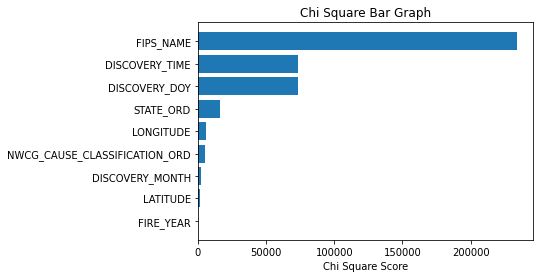

In [15]:
plt.barh(chi['Feature'],chi['Score'])
plt.xlabel("Chi Square Score")
plt.title("Chi Square Bar Graph")
plt.show()

# With missing values(NaN), models cannot be trained!

Below code will show the error!

In [16]:
#### split data into training, validation, and testing
X = Fires[['FIRE_YEAR','DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y = Fires['FIRE_SIZE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#### List of models
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR] #GaussianNB, 
################################################################################################################################               
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print("MSE = ", model_mse, '\n', "MAE = ", model_mae)

<class 'sklearn.linear_model._base.LinearRegression'>


ValueError: ignored

# MODEL

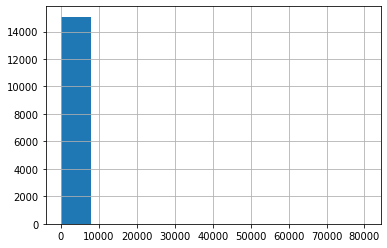

In [19]:
Fires_KNN['FIRE_SIZE'].hist()

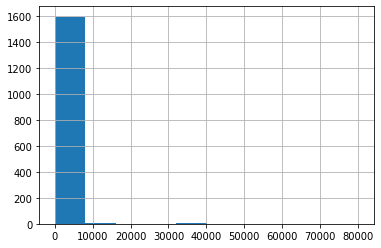

In [20]:
Fires_KNN[Fires_KNN['FIRE_SIZE'] >= 15]['FIRE_SIZE'].hist()

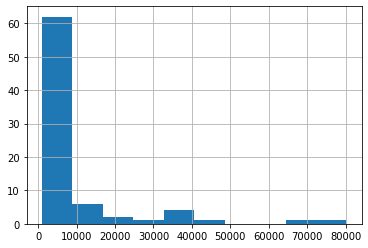

In [21]:
Fires_KNN[Fires_KNN['FIRE_SIZE'] >= 1000]['FIRE_SIZE'].hist()

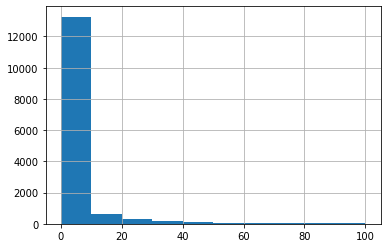

In [22]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(0,100)]['FIRE_SIZE'].hist()

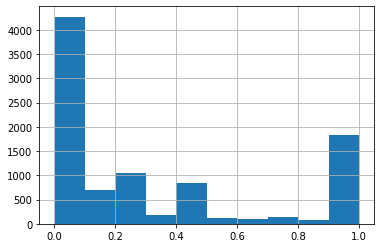

In [23]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(0,1)]['FIRE_SIZE'].hist()

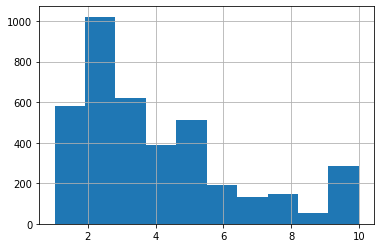

In [24]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(1.01,10)]['FIRE_SIZE'].hist()

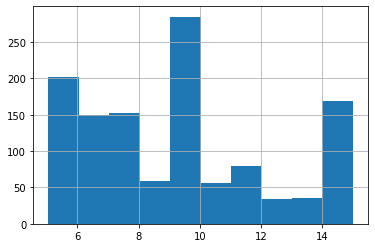

In [25]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(5.01,15)]['FIRE_SIZE'].hist()

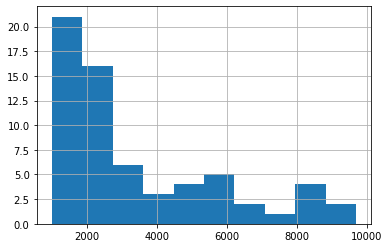

In [26]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(1000,10000)]['FIRE_SIZE'].hist()

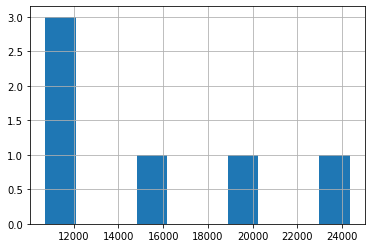

In [27]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(10000,30000)]['FIRE_SIZE'].hist()

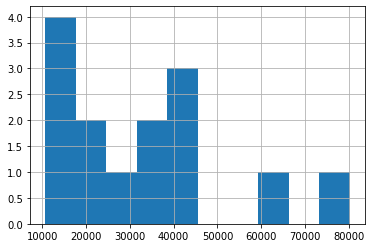

In [28]:
Fires_KNN[Fires_KNN['FIRE_SIZE'].between(10000,333330000)]['FIRE_SIZE'].hist()

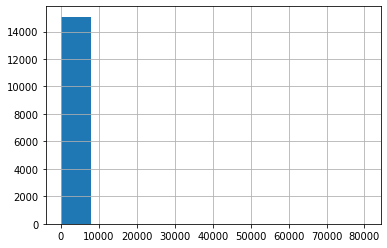

In [29]:
Fires['FIRE_SIZE'].hist()

# Trial 1
  - Use all data to predict fire size

## Create the baseline
 - Use all the data to predict fire size in year 2018

In [30]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [31]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.027463e+06,133.198723
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.077614e+06,107.689437
1,<class 'sklearn.ensemble._forest.RandomForestR...,2.190110e+06,145.039401
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.243021e+06,148.481369
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.100484e+06,455.706336


- Using Rank 1 feature: FIPS_NAME

In [32]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['FIPS_NAME']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['FIPS_NAME']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [33]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.032076e+06,115.989963
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.034879e+06,106.498974
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.056149e+06,110.717903
3,<class 'sklearn.ensemble._forest.RandomForestR...,2.092771e+06,107.759191
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.119602e+06,100.212303


- Using Rank 1~2 features

In [34]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [35]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.031659e+06,115.302963
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.090115e+06,125.120209
2,<class 'sklearn.ensemble._forest.RandomForestR...,2.104270e+06,118.613378
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.146042e+06,122.510371
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.387176e+06,713.037972


- Using Rank 1~3 features

In [36]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [37]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.031659e+06,115.302963
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.090115e+06,125.120209
2,<class 'sklearn.ensemble._forest.RandomForestR...,2.124088e+06,118.184806
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.141522e+06,121.029376
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.131693e+07,1421.073869


- Using Rank 1~4 features

In [38]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [39]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.034608e+06,112.640599
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.112258e+06,132.411239
2,<class 'sklearn.ensemble._forest.RandomForestR...,2.187473e+06,131.852444
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.452043e+06,135.229927
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.644607e+07,2844.974012


- Using Rank 1~5 features

In [40]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [41]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.028404e+06,130.242288
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.084093e+06,107.651429
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.104969e+06,132.377248
2,<class 'sklearn.ensemble._forest.RandomForestR...,2.323367e+06,147.013477
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.559369e+07,4468.047330


- Using Rank 1~6 features

In [42]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE','NWCG_CAUSE_CLASSIFICATION_ORD']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE','NWCG_CAUSE_CLASSIFICATION_ORD']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [43]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.027786e+06,131.892674
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.082925e+06,107.083331
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.113014e+06,136.310907
2,<class 'sklearn.ensemble._forest.RandomForestR...,2.345289e+06,155.367112
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.445158e+06,297.317312


- Using Rank 1~7 features

In [44]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE','NWCG_CAUSE_CLASSIFICATION_ORD','LATITUDE']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE','NWCG_CAUSE_CLASSIFICATION_ORD','LATITUDE']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [45]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.027479e+06,133.047039
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.077617e+06,107.741258
1,<class 'sklearn.ensemble._forest.RandomForestR...,2.233944e+06,140.923165
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.245268e+06,149.808058
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.655743e+07,2228.941173


- Using Rank 1~8 features

In [46]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE','NWCG_CAUSE_CLASSIFICATION_ORD','LATITUDE','DISCOVERY_MONTH']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_TIME','FIPS_NAME','DISCOVERY_DOY','STATE_ORD','LONGITUDE','NWCG_CAUSE_CLASSIFICATION_ORD','LATITUDE','DISCOVERY_MONTH']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [47]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_mse = mean_squared_error(y_KNN_pred,y_KNN_test)
  model_KNN_mae = mean_absolute_error(y_KNN_pred,y_KNN_test)
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'MSE':model_KNN_mse,'MAE':model_KNN_mae}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='MSE', ascending= True)
model_KNN_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,2.027463e+06,133.198723
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.077614e+06,107.689437
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.254597e+06,150.620926
2,<class 'sklearn.ensemble._forest.RandomForestR...,2.323626e+06,148.112420
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.373764e+07,4280.460136


## Use ensemble method

In [48]:
from sklearn.ensemble import VotingRegressor
# Models
r1_t1 = LinearRegression()
r2_t1 = RandomForestRegressor()
r3_t1 = GradientBoostingRegressor()
r4_t1 = AdaBoostRegressor()
r5_t1 = KNeighborsRegressor()
# Possible ensembles
est_t1c1=[('reg1', r1_t1), ('reg2', r2_t1)]
est_t1c2=[('reg1', r1_t1), ('reg3', r3_t1)]
est_t1c3=[('reg1', r1_t1), ('reg4', r4_t1)]
est_t1c4=[('reg1', r1_t1), ('reg5', r5_t1)]
est_t1c5=[('reg2', r2_t1), ('reg3', r3_t1)]
est_t1c6=[('reg2', r2_t1), ('reg4', r4_t1)]
est_t1c7=[('reg2', r2_t1), ('reg5', r5_t1)]
est_t1c8=[('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c9=[('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c10=[('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c11=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1)]
est_t1c12=[('reg1', r1_t1), ('reg2', r2_t1), ('reg4', r4_t1)]
est_t1c13=[('reg1', r1_t1), ('reg2', r2_t1), ('reg5', r5_t1)]
est_t1c14=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c15=[('reg1', r1_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c16=[('reg1', r1_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c17=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c18=[('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c19=[('reg2', r2_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c20=[('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c21=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1)]
est_t1c22=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg5', r5_t1)]
est_t1c23=[('reg1', r1_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c24=[('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
est_t1c25=[('reg1', r1_t1), ('reg2', r2_t1), ('reg3', r3_t1), ('reg4', r4_t1), ('reg5', r5_t1)]
ens_list = [est_t1c1,est_t1c2,est_t1c3,est_t1c4,est_t1c5,est_t1c6,est_t1c7,est_t1c8,est_t1c9,est_t1c10,
            est_t1c11,est_t1c12,est_t1c13,est_t1c14,est_t1c15,est_t1c16,est_t1c17,est_t1c18,est_t1c19,est_t1c20,
            est_t1c21,est_t1c22,est_t1c23,est_t1c24,est_t1c25]
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']
model_ens_t1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t1 = VotingRegressor(i).fit(X_KNN_train,X_KNN_test)
  # Predict with our ensemble model
  ensemble_t1_pred = ensemble_t1.predict(y_KNN_train)
  model_ens_t1_mse = mean_squared_error(ensemble_t1_pred,y_KNN_test)
  model_ens_t1_mae = mean_absolute_error(ensemble_t1_pred,y_KNN_test)
  model_scores_ens_t1 = (ensemble_t1,y_KNN_test,ensemble_t1_pred)
  model_ens_t1_df = model_ens_t1_df.append({'Model':i,'MSE':model_ens_t1_mse,'MAE':model_ens_t1_mae}, ignore_index=True)
  model_ens_t1_df = model_ens_t1_df.sort_values(by='MSE', ascending= True)
model_ens_t1_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg5, KNeighbors...",2.041773e+06,118.886910
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",2.063786e+06,127.604002
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",2.067204e+06,127.975312
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",2.080765e+06,131.373788
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",2.085126e+06,139.167189


In [49]:
model_ens_t1_df['Model'][0]

[('reg1', LinearRegression()), ('reg5', KNeighborsRegressor())]

# Need to Reduce MSE!

# Trial 2 (Divide dataset by fire size)
  - Division number: 10

- 1st Division (Fire Size < 1)

  - GradientBoostingRegressor outperformed!

In [50]:
# 1st Division (Fire Size < 1)
Fires_t2_div1 = Fires_KNN[Fires_KNN['FIRE_SIZE'] <= 1]
XT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d1_train = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d1_test = Fires_t2_div1[Fires_t2_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [51]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d1 = dict()       
model_T2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d1 = model().fit(XT2d1_train,XT2d1_test)
  y_T2d1_pred = regressor_T2d1.predict(yT2d1_train)
  model_T2d1_mse = mean_squared_error(y_T2d1_pred,yT2d1_test)
  model_T2d1_mae = mean_absolute_error(y_T2d1_pred,yT2d1_test)
  model_scores_T2d1[model] = (regressor_T2d1,yT2d1_test,y_T2d1_pred)
  model_T2d1_df = model_T2d1_df.append({'Model':model,'MSE':model_T2d1_mse,'MAE':model_T2d1_mae}, ignore_index=True)
  model_T2d1_df = model_T2d1_df.sort_values(by='MSE', ascending= True)
model_T2d1_df.head()

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.100576,0.254533
1,<class 'sklearn.ensemble._forest.RandomForestR...,0.110977,0.256181
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.113098,0.296643
3,<class 'sklearn.linear_model._base.LinearRegre...,0.114154,0.288290
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.126386,0.276826


In [52]:
# Ensemble method
model_ens_t2d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d1 = VotingRegressor(i).fit(XT2d1_train,XT2d1_test)
  # Predict with our ensemble model
  ensemble_t2d1_pred = ensemble_t2d1.predict(yT2d1_train)
  model_ens_t2d1_mse = mean_squared_error(ensemble_t2d1_pred,yT2d1_test)
  model_ens_t2d1_mae = mean_absolute_error(ensemble_t2d1_pred,yT2d1_test)
  model_scores_ens_t2d1 = (ensemble_t2d1,yT2d1_test,ensemble_t2d1_pred)
  model_ens_t2d1_df = model_ens_t2d1_df.append({'Model':i,'MSE':model_ens_t2d1_mse,'MAE':model_ens_t2d1_mae}, ignore_index=True)
  model_ens_t2d1_df = model_ens_t2d1_df.sort_values(by='MSE', ascending= True)
model_ens_t2d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.100991,0.253062
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.101324,0.263264
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.102261,0.263863
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.102361,0.266307
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.102501,0.257644


In [53]:
model_ens_t2d1_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 2nd Division (1<= Fire Size <= 2)

  - GradientBoostingRegressor outperformed!

In [54]:
# 2nd Division (1<= Fire Size <= 2)
Fires_t2_div2 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] >= 1) & (Fires_KNN['FIRE_SIZE'] <= 2)]
XT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d2_train = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d2_test = Fires_t2_div2[Fires_t2_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [55]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d2 = dict()       
model_T2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d2 = model().fit(XT2d2_train,XT2d2_test)
  y_T2d2_pred = regressor_T2d2.predict(yT2d2_train)
  model_T2d2_mse = mean_squared_error(y_T2d2_pred,yT2d2_test)
  model_T2d2_mae = mean_absolute_error(y_T2d2_pred,yT2d2_test)
  model_scores_T2d2[model] = (regressor_T2d2,yT2d2_test,y_T2d2_pred)
  model_T2d2_df = model_T2d2_df.append({'Model':model,'MSE':model_T2d2_mse,'MAE':model_T2d2_mae}, ignore_index=True)
  model_T2d2_df = model_T2d2_df.sort_values(by='MSE', ascending= True)
model_T2d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.176616,0.382619
1,<class 'sklearn.linear_model._base.LinearRegre...,0.176689,0.380428
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.183432,0.382132
3,<class 'sklearn.ensemble._forest.RandomForestR...,0.194920,0.381041
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.210175,0.388508


In [56]:
# Ensemble method
model_ens_t2d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d2 = VotingRegressor(i).fit(XT2d2_train,XT2d2_test)
  # Predict with our ensemble model
  ensemble_t2d2_pred = ensemble_t2d2.predict(yT2d2_train)
  model_ens_t2d2_mse = mean_squared_error(ensemble_t2d2_pred,yT2d2_test)
  model_ens_t2d2_mae = mean_absolute_error(ensemble_t2d2_pred,yT2d2_test)
  model_scores_ens_t2d2 = (ensemble_t2d2,yT2d2_test,ensemble_t2d2_pred)
  model_ens_t2d2_df = model_ens_t2d2_df.append({'Model':i,'MSE':model_ens_t2d2_mse,'MAE':model_ens_t2d2_mae}, ignore_index=True)
  model_ens_t2d2_df = model_ens_t2d2_df.sort_values(by='MSE', ascending= True)
model_ens_t2d2_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",0.173120,0.380020
1,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.177878,0.380475
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.178136,0.378755
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.178363,0.381211
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.178606,0.380193


In [57]:
model_ens_t2d2_df['Model'][0]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor())]

- 3rd Division (2< Fire Size <= 5)

  - GradientBoostingRegressor outperformed!

In [58]:
# 3rd Division (2 < Fire Size <= 5)
Fires_t2_div3 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 2) & (Fires_KNN['FIRE_SIZE'] <= 5)]
XT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d3_train = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d3_test = Fires_t2_div3[Fires_t2_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [59]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d3 = dict()       
model_T2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d3 = model().fit(XT2d3_train,XT2d3_test)
  y_T2d3_pred = regressor_T2d3.predict(yT2d3_train)
  model_T2d3_mse = mean_squared_error(y_T2d3_pred,yT2d3_test)
  model_T2d3_mae = mean_absolute_error(y_T2d3_pred,yT2d3_test)
  model_scores_T2d3[model] = (regressor_T2d3,yT2d3_test,y_T2d3_pred)
  model_T2d3_df = model_T2d3_df.append({'Model':model,'MSE':model_T2d3_mse,'MAE':model_T2d3_mae}, ignore_index=True)
  model_T2d3_df = model_T2d3_df.sort_values(by='MSE', ascending= True)
model_T2d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.852083,0.844376
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.863189,0.839171
2,<class 'sklearn.linear_model._base.LinearRegre...,0.895696,0.865237
3,<class 'sklearn.ensemble._forest.RandomForestR...,0.908235,0.833303
4,<class 'sklearn.neighbors._regression.KNeighbo...,1.081394,0.899779


In [60]:
# Ensemble method
model_ens_t2d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d3 = VotingRegressor(i).fit(XT2d3_train,XT2d3_test)
  # Predict with our ensemble model
  ensemble_t2d3_pred = ensemble_t2d3.predict(yT2d3_train)
  model_ens_t2d3_mse = mean_squared_error(ensemble_t2d3_pred,yT2d3_test)
  model_ens_t2d3_mae = mean_absolute_error(ensemble_t2d3_pred,yT2d3_test)
  model_scores_ens_t2d3 = (ensemble_t2d3,yT2d3_test,ensemble_t2d3_pred)
  model_ens_t2d3_df = model_ens_t2d3_df.append({'Model':i,'MSE':model_ens_t2d3_mse,'MAE':model_ens_t2d3_mae}, ignore_index=True)
  model_ens_t2d3_df = model_ens_t2d3_df.sort_values(by='MSE', ascending= True)
model_ens_t2d3_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",0.826724,0.820983
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.846315,0.833344
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.848105,0.844063
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.849158,0.840652
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.853529,0.821984


In [61]:
model_ens_t2d3_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

- 4th Division (5< Fire Size <= 15)

  - LinearRegression outperformed!

In [62]:
# 4th Division (5 < Fire Size <= 15)
Fires_t2_div4 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 5) & (Fires_KNN['FIRE_SIZE'] <= 15)]
XT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d4_train = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d4_test = Fires_t2_div4[Fires_t2_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [63]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d4 = dict()       
model_T2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d4 = model().fit(XT2d4_train,XT2d4_test)
  y_T2d4_pred = regressor_T2d4.predict(yT2d4_train)
  model_T2d4_mse = mean_squared_error(y_T2d4_pred,yT2d4_test)
  model_T2d4_mae = mean_absolute_error(y_T2d4_pred,yT2d4_test)
  model_scores_T2d4[model] = (regressor_T2d4,yT2d4_test,y_T2d4_pred)
  model_T2d4_df = model_T2d4_df.append({'Model':model,'MSE':model_T2d4_mse,'MAE':model_T2d4_mae}, ignore_index=True)
  model_T2d4_df = model_T2d4_df.sort_values(by='MSE', ascending= True)
model_T2d4_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,11.223210,2.878278
4,<class 'sklearn.neighbors._regression.KNeighbo...,12.231765,2.907116
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,12.733864,3.118824
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,13.268993,3.178716
3,<class 'sklearn.ensemble._forest.RandomForestR...,13.581136,3.198872


In [64]:
# Ensemble method
model_ens_t2d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d4 = VotingRegressor(i).fit(XT2d4_train,XT2d4_test)
  # Predict with our ensemble model
  ensemble_t2d4_pred = ensemble_t2d4.predict(yT2d4_train)
  model_ens_t2d4_mse = mean_squared_error(ensemble_t2d4_pred,yT2d4_test)
  model_ens_t2d4_mae = mean_absolute_error(ensemble_t2d4_pred,yT2d4_test)
  model_scores_ens_t2d4 = (ensemble_t2d4,yT2d4_test,ensemble_t2d4_pred)
  model_ens_t2d4_df = model_ens_t2d4_df.append({'Model':i,'MSE':model_ens_t2d4_mse,'MAE':model_ens_t2d4_mae}, ignore_index=True)
  model_ens_t2d4_df = model_ens_t2d4_df.sort_values(by='MSE', ascending= True)
model_ens_t2d4_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg5, KNeighbors...",11.250334,2.866886
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",11.484658,2.907395
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",11.597157,2.949369
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",11.615533,2.940221
4,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",11.698776,2.957954


In [65]:
model_ens_t2d4_df['Model'][0]

[('reg1', LinearRegression()), ('reg5', KNeighborsRegressor())]

- 5th Division (15< Fire Size <= 40)

  - GradientBoostingRegressor outperformed!

In [66]:
# 5th Division (15 < Fire Size <= 40)
Fires_t2_div5 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 15) & (Fires_KNN['FIRE_SIZE'] <= 40)]
XT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d5_train = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d5_test = Fires_t2_div5[Fires_t2_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [67]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d5 = dict()       
model_T2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d5 = model().fit(XT2d5_train,XT2d5_test)
  y_T2d5_pred = regressor_T2d5.predict(yT2d5_train)
  model_T2d5_mse = mean_squared_error(y_T2d5_pred,yT2d5_test)
  model_T2d5_mae = mean_absolute_error(y_T2d5_pred,yT2d5_test)
  model_scores_T2d5[model] = (regressor_T2d5,yT2d5_test,y_T2d5_pred)
  model_T2d5_df = model_T2d5_df.append({'Model':model,'MSE':model_T2d5_mse,'MAE':model_T2d5_mae}, ignore_index=True)
  model_T2d5_df = model_T2d5_df.sort_values(by='MSE', ascending= True)
model_T2d5_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,51.120869,6.182747
1,<class 'sklearn.linear_model._base.LinearRegre...,53.772231,6.070639
2,<class 'sklearn.ensemble._forest.RandomForestR...,59.999951,6.354900
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,60.729858,6.677377
4,<class 'sklearn.neighbors._regression.KNeighbo...,61.146842,6.356800


In [68]:
# Ensemble method
model_ens_t2d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d5 = VotingRegressor(i).fit(XT2d5_train,XT2d5_test)
  # Predict with our ensemble model
  ensemble_t2d5_pred = ensemble_t2d5.predict(yT2d5_train)
  model_ens_t2d5_mse = mean_squared_error(ensemble_t2d5_pred,yT2d5_test)
  model_ens_t2d5_mae = mean_absolute_error(ensemble_t2d5_pred,yT2d5_test)
  model_scores_ens_t2d5 = (ensemble_t2d5,yT2d5_test,ensemble_t2d5_pred)
  model_ens_t2d5_df = model_ens_t2d5_df.append({'Model':i,'MSE':model_ens_t2d5_mse,'MAE':model_ens_t2d5_mae}, ignore_index=True)
  model_ens_t2d5_df = model_ens_t2d5_df.sort_values(by='MSE', ascending= True)
model_ens_t2d5_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",50.549120,5.813752
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",51.456593,6.068710
2,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",51.795677,5.814310
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",53.009930,5.971417
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",53.464129,6.206220


In [69]:
model_ens_t2d5_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg5', KNeighborsRegressor())]

- 6th Division (40< Fire Size <= 150)

  - AdaBoostRegressor outperformed!

In [70]:
# 6th Division (40 < Fire Size <= 150)
Fires_t2_div6 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 40) & (Fires_KNN['FIRE_SIZE'] <= 150)]
XT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d6_train = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d6_test = Fires_t2_div6[Fires_t2_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [71]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d6 = dict()       
model_T2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d6 = model().fit(XT2d6_train,XT2d6_test)
  y_T2d6_pred = regressor_T2d6.predict(yT2d6_train)
  model_T2d6_mse = mean_squared_error(y_T2d6_pred,yT2d6_test)
  model_T2d6_mae = mean_absolute_error(y_T2d6_pred,yT2d6_test)
  model_scores_T2d6[model] = (regressor_T2d6,yT2d6_test,y_T2d6_pred)
  model_T2d6_df = model_T2d6_df.append({'Model':model,'MSE':model_T2d6_mse,'MAE':model_T2d6_mae}, ignore_index=True)
  model_T2d6_df = model_T2d6_df.sort_values(by='MSE', ascending= True)
model_T2d6_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,654.242601,20.486825
4,<class 'sklearn.neighbors._regression.KNeighbo...,674.402164,21.479400
1,<class 'sklearn.linear_model._base.LinearRegre...,740.387526,23.280758
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,745.393661,23.178644
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,858.198817,25.819873


In [72]:
# Ensemble method
model_ens_t2d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d6 = VotingRegressor(i).fit(XT2d6_train,XT2d6_test)
  # Predict with our ensemble model
  ensemble_t2d6_pred = ensemble_t2d6.predict(yT2d6_train)
  model_ens_t2d6_mse = mean_squared_error(ensemble_t2d6_pred,yT2d6_test)
  model_ens_t2d6_mae = mean_absolute_error(ensemble_t2d6_pred,yT2d6_test)
  model_scores_ens_t2d6 = (ensemble_t2d6,yT2d6_test,ensemble_t2d6_pred)
  model_ens_t2d6_df = model_ens_t2d6_df.append({'Model':i,'MSE':model_ens_t2d6_mse,'MAE':model_ens_t2d6_mae}, ignore_index=True)
  model_ens_t2d6_df = model_ens_t2d6_df.sort_values(by='MSE', ascending= True)
model_ens_t2d6_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",635.475908,20.733425
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",650.104884,21.098495
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",652.840649,21.554895
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",657.224640,20.860364
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",667.679787,21.462516


In [73]:
model_ens_t2d6_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg5', KNeighborsRegressor())]

- 7th Division (150< Fire Size <= 600)

  - LinearRegression outperformed!

In [74]:
# 7th Division (150 < Fire Size <= 600)
Fires_t2_div7 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 150) & (Fires_KNN['FIRE_SIZE'] <= 600)]
XT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d7_train = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d7_test = Fires_t2_div7[Fires_t2_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [75]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d7 = dict()       
model_T2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d7 = model().fit(XT2d7_train,XT2d7_test)
  y_T2d7_pred = regressor_T2d7.predict(yT2d7_train)
  model_T2d7_mse = mean_squared_error(y_T2d7_pred,yT2d7_test)
  model_T2d7_mae = mean_absolute_error(y_T2d7_pred,yT2d7_test)
  model_scores_T2d7[model] = (regressor_T2d7,yT2d7_test,y_T2d7_pred)
  model_T2d7_df = model_T2d7_df.append({'Model':model,'MSE':model_T2d7_mse,'MAE':model_T2d7_mae}, ignore_index=True)
  model_T2d7_df = model_T2d7_df.sort_values(by='MSE', ascending= True)
model_T2d7_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,5096.743652,64.122711
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,5879.855632,69.769251
4,<class 'sklearn.neighbors._regression.KNeighbo...,6249.127801,58.448000
2,<class 'sklearn.ensemble._forest.RandomForestR...,7084.298632,63.114450
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,12025.669459,89.684251


In [76]:
# Ensemble method
model_ens_t2d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d7 = VotingRegressor(i).fit(XT2d7_train,XT2d7_test)
  # Predict with our ensemble model
  ensemble_t2d7_pred = ensemble_t2d7.predict(yT2d7_train)
  model_ens_t2d7_mse = mean_squared_error(ensemble_t2d7_pred,yT2d7_test)
  model_ens_t2d7_mae = mean_absolute_error(ensemble_t2d7_pred,yT2d7_test)
  model_scores_ens_t2d7 = (ensemble_t2d7,yT2d7_test,ensemble_t2d7_pred)
  model_ens_t2d7_df = model_ens_t2d7_df.append({'Model':i,'MSE':model_ens_t2d7_mse,'MAE':model_ens_t2d7_mae}, ignore_index=True)
  model_ens_t2d7_df = model_ens_t2d7_df.sort_values(by='MSE', ascending= True)
model_ens_t2d7_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",4348.704407,60.272703
1,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",4372.346713,58.398750
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",4936.593397,62.726997
3,"[(reg1, LinearRegression()), (reg5, KNeighbors...",5013.086980,60.218689
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",5154.274870,63.779272


In [77]:
model_ens_t2d7_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg5', KNeighborsRegressor())]

- 8th Division (600< Fire Size <= 1000)

  - KNeighborsRegressor outperformed!

In [78]:
# 8th Division (600 < Fire Size <= 1000)
Fires_t2_div8 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 600) & (Fires_KNN['FIRE_SIZE'] <= 1000)]
XT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d8_train = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d8_test = Fires_t2_div8[Fires_t2_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [79]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d8 = dict()       
model_T2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d8 = model().fit(XT2d8_train,XT2d8_test)
  y_T2d8_pred = regressor_T2d8.predict(yT2d8_train)
  model_T2d8_mse = mean_squared_error(y_T2d8_pred,yT2d8_test)
  model_T2d8_mae = mean_absolute_error(y_T2d8_pred,yT2d8_test)
  model_scores_T2d8[model] = (regressor_T2d8,yT2d8_test,y_T2d8_pred)
  model_T2d8_df = model_T2d8_df.append({'Model':model,'MSE':model_T2d8_mse,'MAE':model_T2d8_mae}, ignore_index=True)
  model_T2d8_df = model_T2d8_df.sort_values(by='MSE', ascending= True)
model_T2d8_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,1019.591681,22.750500
4,<class 'sklearn.neighbors._regression.KNeighbo...,2035.445800,44.370000
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,2549.441802,47.002923
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,5111.554877,67.372222
3,<class 'sklearn.linear_model._base.LinearRegre...,8728.992480,78.705605


In [80]:
# Ensemble method
model_ens_t2d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d8 = VotingRegressor(i).fit(XT2d8_train,XT2d8_test)
  # Predict with our ensemble model
  ensemble_t2d8_pred = ensemble_t2d8.predict(yT2d8_train)
  model_ens_t2d8_mse = mean_squared_error(ensemble_t2d8_pred,yT2d8_test)
  model_ens_t2d8_mae = mean_absolute_error(ensemble_t2d8_pred,yT2d8_test)
  model_scores_ens_t2d8 = (ensemble_t2d8,yT2d8_test,ensemble_t2d8_pred)
  model_ens_t2d8_df = model_ens_t2d8_df.append({'Model':i,'MSE':model_ens_t2d8_mse,'MAE':model_ens_t2d8_mae}, ignore_index=True)
  model_ens_t2d8_df = model_ens_t2d8_df.sort_values(by='MSE', ascending= True)
model_ens_t2d8_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",198.995815,12.667941
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",215.398420,11.168433
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",327.648037,17.580842
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",398.310825,16.227254
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",441.805965,20.344757


In [81]:
model_ens_t2d8_df['Model'][0]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor())]

- 9th Division (1000< Fire Size <= 10000)

  - LinearRegression outperformed!

In [82]:
# 9th Division (1000 < Fire Size <= 10000)
Fires_t2_div9 = Fires_KNN[(Fires_KNN['FIRE_SIZE'] > 1000) & (Fires_KNN['FIRE_SIZE'] <= 10000)]
XT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d9_train = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d9_test = Fires_t2_div9[Fires_t2_div9['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [83]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d9 = dict()       
model_T2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d9 = model().fit(XT2d9_train,XT2d9_test)
  y_T2d9_pred = regressor_T2d9.predict(yT2d9_train)
  model_T2d9_mse = mean_squared_error(y_T2d9_pred,yT2d9_test)
  model_T2d9_mae = mean_absolute_error(y_T2d9_pred,yT2d9_test)
  model_scores_T2d9[model] = (regressor_T2d9,yT2d9_test,y_T2d9_pred)
  model_T2d9_df = model_T2d9_df.append({'Model':model,'MSE':model_T2d9_mse,'MAE':model_T2d9_mae}, ignore_index=True)
  model_T2d9_df = model_T2d9_df.sort_values(by='MSE', ascending= True)
model_T2d9_df

,Model,MSE,MAE
4,<class 'sklearn.neighbors._regression.KNeighbo...,1.548753e+06,1117.800000
0,<class 'sklearn.linear_model._base.LinearRegre...,5.196582e+06,2119.511928
1,<class 'sklearn.ensemble._forest.RandomForestR...,6.721827e+06,2459.856000
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,8.847556e+06,2156.109974
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,9.073550e+06,2488.017747


In [84]:
# Ensemble method
model_ens_t2d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d9 = VotingRegressor(i).fit(XT2d9_train,XT2d9_test)
  # Predict with our ensemble model
  ensemble_t2d9_pred = ensemble_t2d9.predict(yT2d9_train)
  model_ens_t2d9_mse = mean_squared_error(ensemble_t2d9_pred,yT2d9_test)
  model_ens_t2d9_mae = mean_absolute_error(ensemble_t2d9_pred,yT2d9_test)
  model_scores_ens_t2d9 = (ensemble_t2d9,yT2d9_test,ensemble_t2d9_pred)
  model_ens_t2d9_df = model_ens_t2d9_df.append({'Model':i,'MSE':model_ens_t2d9_mse,'MAE':model_ens_t2d9_mae}, ignore_index=True)
  model_ens_t2d9_df = model_ens_t2d9_df.sort_values(by='MSE', ascending= True)
model_ens_t2d9_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg5, KNeighbors...",3.093167e+06,1618.655964
1,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",3.634217e+06,1695.537288
2,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",3.687838e+06,1736.968652
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",4.064366e+06,1861.651000
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",4.281936e+06,1764.860657


In [85]:
model_ens_t2d9_df['Model'][0]

[('reg1', LinearRegression()), ('reg5', KNeighborsRegressor())]

- 10th Division (Fire Size > 10000)

  - KNeighborsRegressor outperformed!

In [86]:
# 10th Division (Fire Size > 10000)
Fires_t2_div10 = Fires_KNN[Fires_KNN['FIRE_SIZE'] > 10000]
XT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT2d10_train = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT2d10_test = Fires_t2_div10[Fires_t2_div10['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [87]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T2d10 = dict()       
model_T2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T2d10 = model().fit(XT2d10_train,XT2d10_test)
  y_T2d10_pred = regressor_T2d10.predict(yT2d10_train)
  model_T2d10_mse = mean_squared_error(y_T2d10_pred,yT2d10_test)
  model_T2d10_mae = mean_absolute_error(y_T2d10_pred,yT2d10_test)
  model_scores_T2d10[model] = (regressor_T2d10,yT2d10_test,y_T2d10_pred)
  model_T2d10_df = model_T2d10_df.append({'Model':model,'MSE':model_T2d10_mse,'MAE':model_T2d10_mae}, ignore_index=True)
  model_T2d10_df = model_T2d10_df.sort_values(by='MSE', ascending= True)
model_T2d10_df

,Model,MSE,MAE
4,<class 'sklearn.neighbors._regression.KNeighbo...,7.635264e+07,8738.000000
0,<class 'sklearn.ensemble._forest.RandomForestR...,2.055298e+08,14336.310000
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,2.264122e+08,15047.000000
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,2.695437e+08,16417.785506
3,<class 'sklearn.linear_model._base.LinearRegre...,1.793596e+09,42350.865773


In [88]:
# Ensemble method
model_ens_t2d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t2d10 = VotingRegressor(i).fit(XT2d10_train,XT2d10_test)
  # Predict with our ensemble model
  ensemble_t2d10_pred = ensemble_t2d10.predict(yT2d10_train)
  model_ens_t2d10_mse = mean_squared_error(ensemble_t2d10_pred,yT2d10_test)
  model_ens_t2d10_mae = mean_absolute_error(ensemble_t2d10_pred,yT2d10_test)
  model_scores_ens_t2d10 = (ensemble_t2d10,yT2d10_test,ensemble_t2d10_pred)
  model_ens_t2d10_df = model_ens_t2d10_df.append({'Model':i,'MSE':model_ens_t2d10_mse,'MAE':model_ens_t2d10_mae}, ignore_index=True)
  model_ens_t2d10_df = model_ens_t2d10_df.sort_values(by='MSE', ascending= True)
model_ens_t2d10_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",9.156806e+07,9569.120000
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",1.401999e+08,11840.605892
2,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",1.414316e+08,11892.500000
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",1.595038e+08,12629.480444
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",1.626935e+08,12755.136096


In [89]:
model_ens_t2d10_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg5', KNeighborsRegressor())]

# Trial 3 : Divide by FIRE_SIZE_CLASS
  - Division: Class A vs. Class B vs. Class C vs. Class D vs. Class E vs. Class F vs. Class G

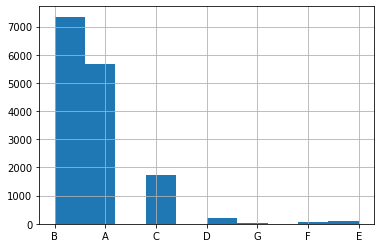

In [90]:
Fires_KNN['FIRE_SIZE_CLASS'].hist()

- 1st Division (Fire Size Class A)

In [91]:
# 1st Division (Fire Size Class A)
Fires_t3_div1 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'A']
XT3d1_train = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d1_test = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d1_train = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d1_test = Fires_t3_div1[Fires_t3_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [92]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d1 = dict()       
model_T3d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d1 = model().fit(XT3d1_train,XT3d1_test)
  y_T3d1_pred = regressor_T3d1.predict(yT3d1_train)
  model_T3d1_mse = mean_squared_error(y_T3d1_pred,yT3d1_test)
  model_T3d1_mae = mean_absolute_error(y_T3d1_pred,yT3d1_test)
  model_scores_T3d1[model] = (regressor_T3d1,yT3d1_test,y_T3d1_pred)
  model_T3d1_df = model_T3d1_df.append({'Model':model,'MSE':model_T3d1_mse,'MAE':model_T3d1_mae}, ignore_index=True)
  model_T3d1_df = model_T3d1_df.sort_values(by='MSE', ascending= True)
model_T3d1_df.head()

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,0.003884,0.046734
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.003926,0.045519
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.004245,0.049376
3,<class 'sklearn.linear_model._base.LinearRegre...,0.005001,0.052868
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.005068,0.054531


In [93]:
# Ensemble method
model_ens_t3d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d1 = VotingRegressor(i).fit(XT3d1_train,XT3d1_test)
  # Predict with our ensemble model
  ensemble_t3d1_pred = ensemble_t3d1.predict(yT3d1_train)
  model_ens_t3d1_mse = mean_squared_error(ensemble_t3d1_pred,yT3d1_test)
  model_ens_t3d1_mae = mean_absolute_error(ensemble_t3d1_pred,yT3d1_test)
  model_scores_ens_t3d1 = (ensemble_t3d1,yT3d1_test,ensemble_t3d1_pred)
  model_ens_t3d1_df = model_ens_t3d1_df.append({'Model':i,'MSE':model_ens_t3d1_mse,'MAE':model_ens_t3d1_mae}, ignore_index=True)
  model_ens_t3d1_df = model_ens_t3d1_df.sort_values(by='MSE', ascending= True)
model_ens_t3d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003775,0.045485
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003959,0.046737
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003995,0.047669
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.004021,0.048108
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.004026,0.047188


In [94]:
model_ens_t3d1_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 2nd Division (Fire Size Class B)

In [95]:
# 2nd Division (Fire Size Class B)
Fires_t3_div2 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'B']
XT3d2_train = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d2_test = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d2_train = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d2_test = Fires_t3_div2[Fires_t3_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [96]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d2 = dict()       
model_T3d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d2 = model().fit(XT3d2_train,XT3d2_test)
  y_T3d2_pred = regressor_T3d2.predict(yT3d2_train)
  model_T3d2_mse = mean_squared_error(y_T3d2_pred,yT3d2_test)
  model_T3d2_mae = mean_absolute_error(y_T3d2_pred,yT3d2_test)
  model_scores_T3d2[model] = (regressor_T3d2,yT3d2_test,y_T3d2_pred)
  model_T3d2_df = model_T3d2_df.append({'Model':model,'MSE':model_T3d2_mse,'MAE':model_T3d2_mae}, ignore_index=True)
  model_T3d2_df = model_T3d2_df.sort_values(by='MSE', ascending= True)
model_T3d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,3.552599,1.448641
1,<class 'sklearn.ensemble._forest.RandomForestR...,3.576074,1.441872
2,<class 'sklearn.linear_model._base.LinearRegre...,3.694525,1.475827
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.476403,1.855356
4,<class 'sklearn.neighbors._regression.KNeighbo...,4.485032,1.566872


In [97]:
# Ensemble method
model_ens_t3d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d2 = VotingRegressor(i).fit(XT3d2_train,XT3d2_test)
  # Predict with our ensemble model
  ensemble_t3d2_pred = ensemble_t3d2.predict(yT3d2_train)
  model_ens_t3d2_mse = mean_squared_error(ensemble_t3d2_pred,yT3d2_test)
  model_ens_t3d2_mae = mean_absolute_error(ensemble_t3d2_pred,yT3d2_test)
  model_scores_ens_t3d2 = (ensemble_t3d2,yT3d2_test,ensemble_t3d2_pred)
  model_ens_t3d2_df = model_ens_t3d2_df.append({'Model':i,'MSE':model_ens_t3d2_mse,'MAE':model_ens_t3d2_mae}, ignore_index=True)
  model_ens_t3d2_df = model_ens_t3d2_df.sort_values(by='MSE', ascending= True)
model_ens_t3d2_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.481302,1.433290
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",3.488384,1.440088
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.526173,1.443260
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",3.576169,1.516539
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",3.595815,1.459390


In [98]:
model_ens_t3d2_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor())]

- 3rd Division (Fire Size Class C)

In [99]:
# 3rd Division (Fire Size Class C)
Fires_t3_div3 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'C']
XT3d3_train = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d3_test = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d3_train = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d3_test = Fires_t3_div3[Fires_t3_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [100]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d3 = dict()       
model_T3d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d3 = model().fit(XT3d3_train,XT3d3_test)
  y_T3d3_pred = regressor_T3d3.predict(yT3d3_train)
  model_T3d3_mse = mean_squared_error(y_T3d3_pred,yT3d3_test)
  model_T3d3_mae = mean_absolute_error(y_T3d3_pred,yT3d3_test)
  model_scores_T3d3[model] = (regressor_T3d3,yT3d3_test,y_T3d3_pred)
  model_T3d3_df = model_T3d3_df.append({'Model':model,'MSE':model_T3d3_mse,'MAE':model_T3d3_mae}, ignore_index=True)
  model_T3d3_df = model_T3d3_df.sort_values(by='MSE', ascending= True)
model_T3d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,392.745462,15.848172
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,403.118255,16.046359
2,<class 'sklearn.linear_model._base.LinearRegre...,418.370114,16.917362
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,450.913612,18.039244
4,<class 'sklearn.neighbors._regression.KNeighbo...,508.177370,16.725481


In [101]:
# Ensemble method
model_ens_t3d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d3 = VotingRegressor(i).fit(XT3d3_train,XT3d3_test)
  # Predict with our ensemble model
  ensemble_t3d3_pred = ensemble_t3d3.predict(yT3d3_train)
  model_ens_t3d3_mse = mean_squared_error(ensemble_t3d3_pred,yT3d3_test)
  model_ens_t3d3_mae = mean_absolute_error(ensemble_t3d3_pred,yT3d3_test)
  model_scores_ens_t3d3 = (ensemble_t3d3,yT3d3_test,ensemble_t3d3_pred)
  model_ens_t3d3_df = model_ens_t3d3_df.append({'Model':i,'MSE':model_ens_t3d3_mse,'MAE':model_ens_t3d3_mae}, ignore_index=True)
  model_ens_t3d3_df = model_ens_t3d3_df.sort_values(by='MSE', ascending= True)
model_ens_t3d3_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",366.208671,15.410971
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",385.253214,16.239477
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",385.356305,16.287957
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",385.582164,15.907946
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",385.745229,15.713674


In [102]:
model_ens_t3d3_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 4th Division (Fire Size Class D)

In [103]:
# 4th Division (Fire Size Class D)
Fires_t3_div4 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'D']
XT3d4_train = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d4_test = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d4_train = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d4_test = Fires_t3_div4[Fires_t3_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [104]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d4 = dict()       
model_T3d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d4 = model().fit(XT3d4_train,XT3d4_test)
  y_T3d4_pred = regressor_T3d4.predict(yT3d4_train)
  model_T3d4_mse = mean_squared_error(y_T3d4_pred,yT3d4_test)
  model_T3d4_mae = mean_absolute_error(y_T3d4_pred,yT3d4_test)
  model_scores_T3d4[model] = (regressor_T3d4,yT3d4_test,y_T3d4_pred)
  model_T3d4_df = model_T3d4_df.append({'Model':model,'MSE':model_T3d4_mse,'MAE':model_T3d4_mae}, ignore_index=True)
  model_T3d4_df = model_T3d4_df.sort_values(by='MSE', ascending= True)
model_T3d4_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,4076.439900,57.633755
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,4223.328297,55.927727
2,<class 'sklearn.ensemble._forest.RandomForestR...,4615.279137,59.646523
4,<class 'sklearn.neighbors._regression.KNeighbo...,5042.554369,60.436769
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,5284.379683,64.229719


In [105]:
# Ensemble method
model_ens_t3d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d4 = VotingRegressor(i).fit(XT3d4_train,XT3d4_test)
  # Predict with our ensemble model
  ensemble_t3d4_pred = ensemble_t3d4.predict(yT3d4_train)
  model_ens_t3d4_mse = mean_squared_error(ensemble_t3d4_pred,yT3d4_test)
  model_ens_t3d4_mae = mean_absolute_error(ensemble_t3d4_pred,yT3d4_test)
  model_scores_ens_t3d4 = (ensemble_t3d4,yT3d4_test,ensemble_t3d4_pred)
  model_ens_t3d4_df = model_ens_t3d4_df.append({'Model':i,'MSE':model_ens_t3d4_mse,'MAE':model_ens_t3d4_mae}, ignore_index=True)
  model_ens_t3d4_df = model_ens_t3d4_df.sort_values(by='MSE', ascending= True)
model_ens_t3d4_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",4016.354072,56.738432
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",4139.329604,56.289766
2,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",4160.592162,57.076383
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",4191.237096,57.546155
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",4244.104274,57.867623


In [106]:
model_ens_t3d4_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor())]

- 5th Division (Fire Size Class E)

In [107]:
# 5th Division (Fire Size Class E)
Fires_t3_div5 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'E']
XT3d5_train = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d5_test = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d5_train = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d5_test = Fires_t3_div5[Fires_t3_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [108]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d5 = dict()       
model_T3d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d5 = model().fit(XT3d5_train,XT3d5_test)
  y_T3d5_pred = regressor_T3d5.predict(yT3d5_train)
  model_T3d5_mse = mean_squared_error(y_T3d5_pred,yT3d5_test)
  model_T3d5_mae = mean_absolute_error(y_T3d5_pred,yT3d5_test)
  model_scores_T3d5[model] = (regressor_T3d5,yT3d5_test,y_T3d5_pred)
  model_T3d5_df = model_T3d5_df.append({'Model':model,'MSE':model_T3d5_mse,'MAE':model_T3d5_mae}, ignore_index=True)
  model_T3d5_df = model_T3d5_df.sort_values(by='MSE', ascending= True)
model_T3d5_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,65951.281002,240.121618
1,<class 'sklearn.ensemble._forest.RandomForestR...,75658.880964,261.830000
4,<class 'sklearn.neighbors._regression.KNeighbo...,80506.152720,252.252000
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,85361.246828,262.683288
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,96256.110267,271.439774


In [109]:
# Ensemble method
model_ens_t3d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d5 = VotingRegressor(i).fit(XT3d5_train,XT3d5_test)
  # Predict with our ensemble model
  ensemble_t3d5_pred = ensemble_t3d5.predict(yT3d5_train)
  model_ens_t3d5_mse = mean_squared_error(ensemble_t3d5_pred,yT3d5_test)
  model_ens_t3d5_mae = mean_absolute_error(ensemble_t3d5_pred,yT3d5_test)
  model_scores_ens_t3d5 = (ensemble_t3d5,yT3d5_test,ensemble_t3d5_pred)
  model_ens_t3d5_df = model_ens_t3d5_df.append({'Model':i,'MSE':model_ens_t3d5_mse,'MAE':model_ens_t3d5_mae}, ignore_index=True)
  model_ens_t3d5_df = model_ens_t3d5_df.sort_values(by='MSE', ascending= True)
model_ens_t3d5_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",63599.414802,235.438042
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",66125.863947,238.949124
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",67192.126740,249.913509
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",67494.032091,241.167863
4,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",68232.655472,247.666001


In [110]:
model_ens_t3d5_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor()),
 ('reg5', KNeighborsRegressor())]

- 6th Division (Fire Size Class F)

In [111]:
# 6th Division (Fire Size Class F)
Fires_t3_div6 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'F']
XT3d6_train = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d6_test = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d6_train = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d6_test = Fires_t3_div6[Fires_t3_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [112]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d6 = dict()       
model_T3d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d6 = model().fit(XT3d6_train,XT3d6_test)
  y_T3d6_pred = regressor_T3d6.predict(yT3d6_train)
  model_T3d6_mse = mean_squared_error(y_T3d6_pred,yT3d6_test)
  model_T3d6_mae = mean_absolute_error(y_T3d6_pred,yT3d6_test)
  model_scores_T3d6[model] = (regressor_T3d6,yT3d6_test,y_T3d6_pred)
  model_T3d6_df = model_T3d6_df.append({'Model':model,'MSE':model_T3d6_mse,'MAE':model_T3d6_mae}, ignore_index=True)
  model_T3d6_df = model_T3d6_df.sort_values(by='MSE', ascending= True)
model_T3d6_df

,Model,MSE,MAE
4,<class 'sklearn.neighbors._regression.KNeighbo...,55144.476000,194.000000
0,<class 'sklearn.linear_model._base.LinearRegre...,197511.215573,353.500132
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,379056.204235,571.901270
2,<class 'sklearn.ensemble._forest.RandomForestR...,517933.934650,636.522000
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,713753.225227,670.953279


In [113]:
# Ensemble method
model_ens_t3d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d6 = VotingRegressor(i).fit(XT3d6_train,XT3d6_test)
  # Predict with our ensemble model
  ensemble_t3d6_pred = ensemble_t3d6.predict(yT3d6_train)
  model_ens_t3d6_mse = mean_squared_error(ensemble_t3d6_pred,yT3d6_test)
  model_ens_t3d6_mae = mean_absolute_error(ensemble_t3d6_pred,yT3d6_test)
  model_scores_ens_t3d6 = (ensemble_t3d6,yT3d6_test,ensemble_t3d6_pred)
  model_ens_t3d6_df = model_ens_t3d6_df.append({'Model':i,'MSE':model_ens_t3d6_mse,'MAE':model_ens_t3d6_mae}, ignore_index=True)
  model_ens_t3d6_df = model_ens_t3d6_df.sort_values(by='MSE', ascending= True)
model_ens_t3d6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg5, KNeighbors...",37805.205546,170.677109
1,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",39710.328745,192.092734
2,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",75298.606414,229.618885
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",115505.525540,264.016990
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",137682.554011,304.005393


In [114]:
model_ens_t3d6_df['Model'][0]

[('reg1', LinearRegression()), ('reg5', KNeighborsRegressor())]

- 7th Division (Fire Size Class G)

In [115]:
# 7th Division (Fire Size Class G)
Fires_t3_div7 = Fires_KNN[Fires_KNN['FIRE_SIZE_CLASS'] == 'G']
XT3d7_train = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d7_test = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d7_train = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d7_test = Fires_t3_div7[Fires_t3_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [116]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d7 = dict()       
model_T3d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d7 = model().fit(XT3d7_train,XT3d7_test)
  y_T3d7_pred = regressor_T3d7.predict(yT3d7_train)
  model_T3d7_mse = mean_squared_error(y_T3d7_pred,yT3d7_test)
  model_T3d7_mae = mean_absolute_error(y_T3d7_pred,yT3d7_test)
  model_scores_T3d7[model] = (regressor_T3d7,yT3d7_test,y_T3d7_pred)
  model_T3d7_df = model_T3d7_df.append({'Model':model,'MSE':model_T3d7_mse,'MAE':model_T3d7_mae}, ignore_index=True)
  model_T3d7_df = model_T3d7_df.sort_values(by='MSE', ascending= True)
model_T3d7_df

,Model,MSE,MAE
4,<class 'sklearn.neighbors._regression.KNeighbo...,1.855752e+08,13622.600000
0,<class 'sklearn.ensemble._forest.RandomForestR...,6.933179e+08,26330.930000
1,<class 'sklearn.linear_model._base.LinearRegre...,8.427046e+08,29029.374846
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,9.534354e+08,30877.750000
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,9.588639e+08,30965.528108


In [117]:
# Ensemble method
model_ens_t3d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d7 = VotingRegressor(i).fit(XT3d7_train,XT3d7_test)
  # Predict with our ensemble model
  ensemble_t3d7_pred = ensemble_t3d7.predict(yT3d7_train)
  model_ens_t3d7_mse = mean_squared_error(ensemble_t3d7_pred,yT3d7_test)
  model_ens_t3d7_mae = mean_absolute_error(ensemble_t3d7_pred,yT3d7_test)
  model_scores_ens_t3d7 = (ensemble_t3d7,yT3d7_test,ensemble_t3d7_pred)
  model_ens_t3d7_df = model_ens_t3d7_df.append({'Model':i,'MSE':model_ens_t3d7_mse,'MAE':model_ens_t3d7_mae}, ignore_index=True)
  model_ens_t3d7_df = model_ens_t3d7_df.sort_values(by='MSE', ascending= True)
model_ens_t3d7_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",3.708436e+08,19257.300000
1,"[(reg1, LinearRegression()), (reg5, KNeighbors...",4.547977e+08,21325.987423
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",4.698639e+08,21676.345000
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",5.058670e+08,22491.486191
4,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",5.560075e+08,23579.810909


In [118]:
model_ens_t3d7_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg5', KNeighborsRegressor())]

- 8th Division (Fire Size Class D,E,F,G)

In [119]:
# 8th Division (Fire Size Class D,E,F,G)
Fires_t3_div8 = Fires_KNN[(Fires_KNN['FIRE_SIZE_CLASS'] == 'D') | (Fires_KNN['FIRE_SIZE_CLASS'] == 'E') | (Fires_KNN['FIRE_SIZE_CLASS'] == 'F') | (Fires_KNN['FIRE_SIZE_CLASS'] == 'G')]
XT3d8_train = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT3d8_test = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT3d8_train = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT3d8_test = Fires_t3_div8[Fires_t3_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [120]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T3d8 = dict()       
model_T3d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T3d8 = model().fit(XT3d8_train,XT3d8_test)
  y_T3d8_pred = regressor_T3d8.predict(yT3d8_train)
  model_T3d8_mse = mean_squared_error(y_T3d8_pred,yT3d8_test)
  model_T3d8_mae = mean_absolute_error(y_T3d8_pred,yT3d8_test)
  model_scores_T3d8[model] = (regressor_T3d8,yT3d8_test,y_T3d8_pred)
  model_T3d8_df = model_T3d8_df.append({'Model':model,'MSE':model_T3d8_mse,'MAE':model_T3d8_mae}, ignore_index=True)
  model_T3d8_df = model_T3d8_df.sort_values(by='MSE', ascending= True)
model_T3d8_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,6.303172e+07,4071.105442
4,<class 'sklearn.neighbors._regression.KNeighbo...,6.515568e+07,3084.589583
1,<class 'sklearn.ensemble._forest.RandomForestR...,8.303349e+07,4436.774475
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.103373e+08,7563.461990
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.333707e+08,4929.276700


In [121]:
# Ensemble method
model_ens_t3d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t3d8 = VotingRegressor(i).fit(XT3d8_train,XT3d8_test)
  # Predict with our ensemble model
  ensemble_t3d8_pred = ensemble_t3d8.predict(yT3d8_train)
  model_ens_t3d8_mse = mean_squared_error(ensemble_t3d8_pred,yT3d8_test)
  model_ens_t3d8_mae = mean_absolute_error(ensemble_t3d8_pred,yT3d8_test)
  model_scores_ens_t3d8 = (ensemble_t3d8,yT3d8_test,ensemble_t3d8_pred)
  model_ens_t3d8_df = model_ens_t3d8_df.append({'Model':i,'MSE':model_ens_t3d8_mse,'MAE':model_ens_t3d8_mae}, ignore_index=True)
  model_ens_t3d8_df = model_ens_t3d8_df.sort_values(by='MSE', ascending= True)
model_ens_t3d8_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg5, KNeighbors...",6.233998e+07,3523.869846
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",6.469093e+07,3663.240957
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",6.825556e+07,3594.068894
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",6.964619e+07,4125.732932
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",7.095553e+07,3939.958680


In [122]:
model_ens_t3d8_df['Model'][0]

[('reg1', LinearRegression()), ('reg5', KNeighborsRegressor())]

# Trail4: SMOTER: Handle imbalance data

In [123]:
pip install smogn

In [124]:
import smogn
Smoter_KNN = smogn.smoter(

    data = Fires_KNN.reset_index(), 
    y = "FIRE_SIZE"
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
r_index: 100%|##########| 1109/1109 [00:03<00:00, 312.52it/s]


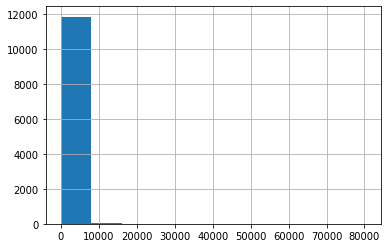

In [125]:
Smoter_KNN['FIRE_SIZE'].hist()

### Baseline of SMOTER

In [126]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_SMOTER_train = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
X_SMOTER_test = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_SMOTER_train = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_SMOTER_test = Smoter_KNN[Smoter_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [127]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_SMOTER = dict()    
model_SMOTER_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_SMOTER = model().fit(X_SMOTER_train,X_SMOTER_test)
  y_SMOTER_pred = regressor_SMOTER.predict(y_SMOTER_train)
  model_SMOTER_mse = mean_squared_error(y_SMOTER_pred,y_SMOTER_test)
  model_SMOTER_mae = mean_absolute_error(y_SMOTER_pred,y_SMOTER_test)
  model_scores_SMOTER[model] = (regressor_SMOTER,y_SMOTER_test,y_SMOTER_pred)
  model_SMOTER_df = model_SMOTER_df.append({'Model':model,'MSE':model_SMOTER_mse,'MAE':model_SMOTER_mae}, ignore_index=True)
  model_SMOTER_df = model_SMOTER_df.sort_values(by='MSE', ascending= True)
model_SMOTER_df

,Model,MSE,MAE
0,<class 'sklearn.linear_model._base.LinearRegre...,4.009241e+06,335.820323
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,4.195593e+06,321.574684
2,<class 'sklearn.ensemble._forest.RandomForestR...,4.265674e+06,284.392986
4,<class 'sklearn.neighbors._regression.KNeighbo...,4.833299e+06,323.360944
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,3.622396e+07,3737.960879


## Use ensemble method

In [128]:
model_ens_t4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4 = VotingRegressor(i).fit(X_SMOTER_train,X_SMOTER_test)
  # Predict with our ensemble model
  ensemble_t4_pred = ensemble_t4.predict(y_SMOTER_train)
  model_ens_t4_mse = mean_squared_error(ensemble_t4_pred,y_SMOTER_test)
  model_ens_t4_mae = mean_absolute_error(ensemble_t4_pred,y_SMOTER_test)
  model_scores_ens_t4 = (ensemble_t4,y_SMOTER_test,ensemble_t4_pred)
  model_ens_t4_df = model_ens_t4_df.append({'Model':i,'MSE':model_ens_t4_mse,'MAE':model_ens_t4_mae}, ignore_index=True)
  model_ens_t4_df = model_ens_t4_df.sort_values(by='MSE', ascending= True)
model_ens_t4_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",4.062587e+06,316.340525
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",4.106786e+06,309.888088
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",4.131121e+06,309.217763
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",4.142887e+06,304.477059
4,"[(reg1, LinearRegression()), (reg3, GradientBo...",4.162456e+06,312.777867


- 1st Division (Fire Size < 1)

In [129]:
# 1st Division (Fire Size < 1)
Fires_t4_div1 = Smoter_KNN[Smoter_KNN['FIRE_SIZE'] <= 1]
XT4d1_train = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d1_test = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d1_train = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d1_test = Fires_t4_div1[Fires_t4_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [130]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR]
model_scores_T4d1 = dict()       
model_T4d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d1 = model().fit(XT4d1_train,XT4d1_test)
  y_T4d1_pred = regressor_T4d1.predict(yT4d1_train)
  model_T4d1_mse = mean_squared_error(y_T4d1_pred,yT4d1_test)
  model_T4d1_mae = mean_absolute_error(y_T4d1_pred,yT4d1_test)
  model_scores_T4d1[model] = (regressor_T4d1,yT4d1_test,y_T4d1_pred)
  model_T4d1_df = model_T4d1_df.append({'Model':model,'MSE':model_T4d1_mse,'MAE':model_T4d1_mae}, ignore_index=True)
  model_T4d1_df = model_T4d1_df.sort_values(by='MSE', ascending= True)
model_T4d1_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.099937,0.263296
5,<class 'sklearn.svm._classes.SVR'>,0.102041,0.246459
1,<class 'sklearn.ensemble._forest.RandomForestR...,0.107471,0.251330
2,<class 'sklearn.linear_model._base.LinearRegre...,0.109326,0.288181
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.112447,0.298385
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.146157,0.317923


In [131]:
# Ensemble method
model_ens_t4d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d1 = VotingRegressor(i).fit(XT4d1_train,XT4d1_test)
  # Predict with our ensemble model
  ensemble_t4d1_pred = ensemble_t4d1.predict(yT4d1_train)
  model_ens_t4d1_mse = mean_squared_error(ensemble_t4d1_pred,yT4d1_test)
  model_ens_t4d1_mae = mean_absolute_error(ensemble_t4d1_pred,yT4d1_test)
  model_scores_ens_t4d1 = (ensemble_t4d1,yT4d1_test,ensemble_t4d1_pred)
  model_ens_t4d1_df = model_ens_t4d1_df.append({'Model':i,'MSE':model_ens_t4d1_mse,'MAE':model_ens_t4d1_mae}, ignore_index=True)
  model_ens_t4d1_df = model_ens_t4d1_df.sort_values(by='MSE', ascending= True)
model_ens_t4d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.099549,0.257714
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.099823,0.266365
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.101544,0.268965
3,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.101849,0.274718
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.102049,0.274518


In [132]:
model_ens_t4d1_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 2nd Division (1<= Fire Size <= 2)

In [133]:
# 2nd Division (1<= Fire Size <= 2)
Fires_t4_div2 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] >= 1) & (Smoter_KNN['FIRE_SIZE'] <= 2)]
XT4d2_train = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d2_test = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d2_train = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d2_test = Fires_t4_div2[Fires_t4_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [134]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d2 = dict()       
model_T4d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d2 = model().fit(XT4d2_train,XT4d2_test)
  y_T4d2_pred = regressor_T4d2.predict(yT4d2_train)
  model_T4d2_mse = mean_squared_error(y_T4d2_pred,yT4d2_test)
  model_T4d2_mae = mean_absolute_error(y_T4d2_pred,yT4d2_test)
  model_scores_T4d2[model] = (regressor_T4d2,yT4d2_test,y_T4d2_pred)
  model_T4d2_df = model_T4d2_df.append({'Model':model,'MSE':model_T4d2_mse,'MAE':model_T4d2_mae}, ignore_index=True)
  model_T4d2_df = model_T4d2_df.sort_values(by='MSE', ascending= True)
model_T4d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.193557,0.410660
1,<class 'sklearn.linear_model._base.LinearRegre...,0.198390,0.394082
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.206387,0.384406
3,<class 'sklearn.ensemble._forest.RandomForestR...,0.221377,0.402115
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.228558,0.399400


In [135]:
# Ensemble method
model_ens_t4d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d2 = VotingRegressor(i).fit(XT4d2_train,XT4d2_test)
  # Predict with our ensemble model
  ensemble_t4d2_pred = ensemble_t4d2.predict(yT4d2_train)
  model_ens_t4d2_mse = mean_squared_error(ensemble_t4d2_pred,yT4d2_test)
  model_ens_t4d2_mae = mean_absolute_error(ensemble_t4d2_pred,yT4d2_test)
  model_scores_ens_t4d2 = (ensemble_t4d2,yT4d2_test,ensemble_t4d2_pred)
  model_ens_t4d2_df = model_ens_t4d2_df.append({'Model':i,'MSE':model_ens_t4d2_mse,'MAE':model_ens_t4d2_mae}, ignore_index=True)
  model_ens_t4d2_df = model_ens_t4d2_df.sort_values(by='MSE', ascending= True)
model_ens_t4d2_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",0.190663,0.397395
1,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.193061,0.383161
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",0.195687,0.388915
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.196171,0.391161
4,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",0.196481,0.393323


In [136]:
model_ens_t4d2_df['Model'][0]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor())]

- 3rd Division (2< Fire Size <= 5)

In [137]:
# 3rd Division (2 < Fire Size <= 5)
Fires_t4_div3 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 2) & (Smoter_KNN['FIRE_SIZE'] <= 5)]
XT4d3_train = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d3_test = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d3_train = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d3_test = Fires_t4_div3[Fires_t4_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [138]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d3 = dict()       
model_T4d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d3 = model().fit(XT4d3_train,XT4d3_test)
  y_T4d3_pred = regressor_T4d3.predict(yT4d3_train)
  model_T4d3_mse = mean_squared_error(y_T4d3_pred,yT4d3_test)
  model_T4d3_mae = mean_absolute_error(y_T4d3_pred,yT4d3_test)
  model_scores_T4d3[model] = (regressor_T4d3,yT4d3_test,y_T4d3_pred)
  model_T4d3_df = model_T4d3_df.append({'Model':model,'MSE':model_T4d3_mse,'MAE':model_T4d3_mae}, ignore_index=True)
  model_T4d3_df = model_T4d3_df.sort_values(by='MSE', ascending= True)
model_T4d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,0.511653,0.606326
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.541636,0.660612
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.599642,0.712478
3,<class 'sklearn.linear_model._base.LinearRegre...,0.673859,0.739666
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.940304,0.801310


In [139]:
# Ensemble method
model_ens_t4d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d3 = VotingRegressor(i).fit(XT4d3_train,XT4d3_test)
  # Predict with our ensemble model
  ensemble_t4d3_pred = ensemble_t4d3.predict(yT4d3_train)
  model_ens_t4d3_mse = mean_squared_error(ensemble_t4d3_pred,yT4d3_test)
  model_ens_t4d3_mae = mean_absolute_error(ensemble_t4d3_pred,yT4d3_test)
  model_scores_ens_t4d3 = (ensemble_t4d3,yT4d3_test,ensemble_t4d3_pred)
  model_ens_t4d3_df = model_ens_t4d3_df.append({'Model':i,'MSE':model_ens_t4d3_mse,'MAE':model_ens_t4d3_mae}, ignore_index=True)
  model_ens_t4d3_df = model_ens_t4d3_df.sort_values(by='MSE', ascending= True)
model_ens_t4d3_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.502019,0.624921
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.524880,0.655294
2,"[(reg3, GradientBoostingRegressor()), (reg4, A...",0.539771,0.679935
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.541271,0.666486
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.541274,0.660944


In [140]:
model_ens_t4d3_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 4th Division (5< Fire Size <= 15)

In [141]:
# 4th Division (5 < Fire Size <= 15)
Fires_t4_div4 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 5) & (Smoter_KNN['FIRE_SIZE'] <= 15)]
XT4d4_train = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d4_test = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d4_train = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d4_test = Fires_t4_div4[Fires_t4_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [142]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d4 = dict()       
model_T4d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d4 = model().fit(XT4d4_train,XT4d4_test)
  y_T4d4_pred = regressor_T4d4.predict(yT4d4_train)
  model_T4d4_mse = mean_squared_error(y_T4d4_pred,yT4d4_test)
  model_T4d4_mae = mean_absolute_error(y_T4d4_pred,yT4d4_test)
  model_scores_T4d4[model] = (regressor_T4d4,yT4d4_test,y_T4d4_pred)
  model_T4d4_df = model_T4d4_df.append({'Model':model,'MSE':model_T4d4_mse,'MAE':model_T4d4_mae}, ignore_index=True)
  model_T4d4_df = model_T4d4_df.sort_values(by='MSE', ascending= True)
model_T4d4_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,9.199822,2.479653
1,<class 'sklearn.linear_model._base.LinearRegre...,9.301435,2.523817
4,<class 'sklearn.neighbors._regression.KNeighbo...,10.575359,2.498962
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,10.807364,2.743956
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,11.286768,2.928330


In [143]:
# Ensemble method
model_ens_t4d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d4 = VotingRegressor(i).fit(XT4d4_train,XT4d4_test)
  # Predict with our ensemble model
  ensemble_t4d4_pred = ensemble_t4d4.predict(yT4d4_train)
  model_ens_t4d4_mse = mean_squared_error(ensemble_t4d4_pred,yT4d4_test)
  model_ens_t4d4_mae = mean_absolute_error(ensemble_t4d4_pred,yT4d4_test)
  model_scores_ens_t4d4 = (ensemble_t4d4,yT4d4_test,ensemble_t4d4_pred)
  model_ens_t4d4_df = model_ens_t4d4_df.append({'Model':i,'MSE':model_ens_t4d4_mse,'MAE':model_ens_t4d4_mae}, ignore_index=True)
  model_ens_t4d4_df = model_ens_t4d4_df.sort_values(by='MSE', ascending= True)
model_ens_t4d4_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",8.803005,2.456211
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",8.996224,2.465720
2,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",9.192798,2.444730
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",9.327194,2.525639
4,"[(reg1, LinearRegression()), (reg5, KNeighbors...",9.332542,2.485566


In [144]:
model_ens_t4d4_df['Model'][0]

[('reg1', LinearRegression()), ('reg2', RandomForestRegressor())]

- 5th Division (15< Fire Size <= 40)

In [145]:
# 5th Division (15 < Fire Size <= 40)
Fires_t4_div5 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 15) & (Smoter_KNN['FIRE_SIZE'] <= 40)]
XT4d5_train = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d5_test = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d5_train = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d5_test = Fires_t4_div5[Fires_t4_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [146]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d5 = dict()       
model_T4d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d5 = model().fit(XT4d5_train,XT4d5_test)
  y_T4d5_pred = regressor_T4d5.predict(yT4d5_train)
  model_T4d5_mse = mean_squared_error(y_T4d5_pred,yT4d5_test)
  model_T4d5_mae = mean_absolute_error(y_T4d5_pred,yT4d5_test)
  model_scores_T4d5[model] = (regressor_T4d5,yT4d5_test,y_T4d5_pred)
  model_T4d5_df = model_T4d5_df.append({'Model':model,'MSE':model_T4d5_mse,'MAE':model_T4d5_mae}, ignore_index=True)
  model_T4d5_df = model_T4d5_df.sort_values(by='MSE', ascending= True)
model_T4d5_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,56.263615,6.370599
1,<class 'sklearn.linear_model._base.LinearRegre...,58.241860,6.325587
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,59.688197,6.362076
3,<class 'sklearn.ensemble._forest.RandomForestR...,61.279288,6.327372
4,<class 'sklearn.neighbors._regression.KNeighbo...,66.005307,6.594593


In [147]:
# Ensemble method
model_ens_t4d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d5 = VotingRegressor(i).fit(XT4d5_train,XT4d5_test)
  # Predict with our ensemble model
  ensemble_t4d5_pred = ensemble_t4d5.predict(yT4d5_train)
  model_ens_t4d5_mse = mean_squared_error(ensemble_t4d5_pred,yT4d5_test)
  model_ens_t4d5_mae = mean_absolute_error(ensemble_t4d5_pred,yT4d5_test)
  model_scores_ens_t4d5 = (ensemble_t4d5,yT4d5_test,ensemble_t4d5_pred)
  model_ens_t4d5_df = model_ens_t4d5_df.append({'Model':i,'MSE':model_ens_t4d5_mse,'MAE':model_ens_t4d5_mae}, ignore_index=True)
  model_ens_t4d5_df = model_ens_t4d5_df.sort_values(by='MSE', ascending= True)
model_ens_t4d5_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",53.912442,6.026342
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",54.643792,6.033684
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",54.981656,6.012800
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",55.047817,6.124696
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",55.833659,6.045509


In [148]:
model_ens_t4d5_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

- 6th Division (40< Fire Size <= 150)

In [149]:
# 6th Division (40 < Fire Size <= 150)
Fires_t4_div6 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 40) & (Smoter_KNN['FIRE_SIZE'] <= 150)]
XT4d6_train = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d6_test = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d6_train = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d6_test = Fires_t4_div6[Fires_t4_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [150]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d6 = dict()       
model_T4d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d6 = model().fit(XT4d6_train,XT4d6_test)
  y_T4d6_pred = regressor_T4d6.predict(yT4d6_train)
  model_T4d6_mse = mean_squared_error(y_T4d6_pred,yT4d6_test)
  model_T4d6_mae = mean_absolute_error(y_T4d6_pred,yT4d6_test)
  model_scores_T4d6[model] = (regressor_T4d6,yT4d6_test,y_T4d6_pred)
  model_T4d6_df = model_T4d6_df.append({'Model':model,'MSE':model_T4d6_mse,'MAE':model_T4d6_mae}, ignore_index=True)
  model_T4d6_df = model_T4d6_df.sort_values(by='MSE', ascending= True)
model_T4d6_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,560.957136,18.324905
1,<class 'sklearn.linear_model._base.LinearRegre...,702.002485,22.620468
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,753.352143,22.937527
4,<class 'sklearn.neighbors._regression.KNeighbo...,775.818728,21.380112
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,804.627638,24.856910


In [151]:
# Ensemble method
model_ens_t4d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d6 = VotingRegressor(i).fit(XT4d6_train,XT4d6_test)
  # Predict with our ensemble model
  ensemble_t4d6_pred = ensemble_t4d6.predict(yT4d6_train)
  model_ens_t4d6_mse = mean_squared_error(ensemble_t4d6_pred,yT4d6_test)
  model_ens_t4d6_mae = mean_absolute_error(ensemble_t4d6_pred,yT4d6_test)
  model_scores_ens_t4d6 = (ensemble_t4d6,yT4d6_test,ensemble_t4d6_pred)
  model_ens_t4d6_df = model_ens_t4d6_df.append({'Model':i,'MSE':model_ens_t4d6_mse,'MAE':model_ens_t4d6_mae}, ignore_index=True)
  model_ens_t4d6_df = model_ens_t4d6_df.sort_values(by='MSE', ascending= True)
model_ens_t4d6_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",592.629892,19.699185
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",595.975545,20.316533
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",609.919626,20.099540
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",627.688147,20.433090
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",641.098848,21.763933


In [152]:
model_ens_t4d6_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 7th Division (150< Fire Size <= 1000)

In [153]:
# 7th Division (150 < Fire Size <= 600)
Fires_t4_div7 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 150) & (Smoter_KNN['FIRE_SIZE'] <= 600)]
XT4d7_train = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d7_test = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d7_train = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d7_test = Fires_t4_div7[Fires_t4_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [154]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d7 = dict()       
model_T4d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d7 = model().fit(XT4d7_train,XT4d7_test)
  y_T4d7_pred = regressor_T4d7.predict(yT4d7_train)
  model_T4d7_mse = mean_squared_error(y_T4d7_pred,yT4d7_test)
  model_T4d7_mae = mean_absolute_error(y_T4d7_pred,yT4d7_test)
  model_scores_T4d7[model] = (regressor_T4d7,yT4d7_test,y_T4d7_pred)
  model_T4d7_df = model_T4d7_df.append({'Model':model,'MSE':model_T4d7_mse,'MAE':model_T4d7_mae}, ignore_index=True)
  model_T4d7_df = model_T4d7_df.sort_values(by='MSE', ascending= True)
model_T4d7_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,4719.619501,56.663500
1,<class 'sklearn.linear_model._base.LinearRegre...,4975.682135,66.651241
4,<class 'sklearn.neighbors._regression.KNeighbo...,9103.012607,77.877764
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,9352.745047,85.514325
3,<class 'sklearn.ensemble._forest.RandomForestR...,9366.839974,67.633471


In [155]:
# Ensemble method
model_ens_t4d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d7 = VotingRegressor(i).fit(XT4d7_train,XT4d7_test)
  # Predict with our ensemble model
  ensemble_t4d7_pred = ensemble_t4d7.predict(yT4d7_train)
  model_ens_t4d7_mse = mean_squared_error(ensemble_t4d7_pred,yT4d7_test)
  model_ens_t4d7_mae = mean_absolute_error(ensemble_t4d7_pred,yT4d7_test)
  model_scores_ens_t4d7 = (ensemble_t4d7,yT4d7_test,ensemble_t4d7_pred)
  model_ens_t4d7_df = model_ens_t4d7_df.append({'Model':i,'MSE':model_ens_t4d7_mse,'MAE':model_ens_t4d7_mae}, ignore_index=True)
  model_ens_t4d7_df = model_ens_t4d7_df.sort_values(by='MSE', ascending= True)
model_ens_t4d7_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg3, GradientBo...",4415.801835,60.630814
1,"[(reg1, LinearRegression()), (reg2, RandomFore...",4529.033199,60.201774
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",4565.019686,62.043482
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",4658.576627,59.208590
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",4852.580855,59.011709


In [156]:
model_ens_t4d7_df['Model'][0]

[('reg1', LinearRegression()), ('reg3', GradientBoostingRegressor())]

- 8th Division (600< Fire Size <= 1000)

In [157]:
# 8th Division (600 < Fire Size <= 1000)
Fires_t4_div8 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 600) & (Smoter_KNN['FIRE_SIZE'] <= 1000)]
XT4d8_train = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d8_test = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d8_train = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d8_test = Fires_t4_div8[Fires_t4_div8['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [158]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d8 = dict()       
model_T4d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d8 = model().fit(XT4d8_train,XT4d8_test)
  y_T4d8_pred = regressor_T4d8.predict(yT4d8_train)
  model_T4d8_mse = mean_squared_error(y_T4d8_pred,yT4d8_test)
  model_T4d8_mae = mean_absolute_error(y_T4d8_pred,yT4d8_test)
  model_scores_T4d8[model] = (regressor_T4d8,yT4d8_test,y_T4d8_pred)
  model_T4d8_df = model_T4d8_df.append({'Model':model,'MSE':model_T4d8_mse,'MAE':model_T4d8_mae}, ignore_index=True)
  model_T4d8_df = model_T4d8_df.sort_values(by='MSE', ascending= True)
model_T4d8_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,709.338246,25.005802
1,<class 'sklearn.ensemble._forest.RandomForestR...,1043.135917,32.254081
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,1206.787226,34.737702
4,<class 'sklearn.neighbors._regression.KNeighbo...,1422.391799,32.544456
3,<class 'sklearn.linear_model._base.LinearRegre...,3407.730698,56.721603


In [159]:
# Ensemble method
model_ens_t4d8_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d8 = VotingRegressor(i).fit(XT4d8_train,XT4d8_test)
  # Predict with our ensemble model
  ensemble_t4d8_pred = ensemble_t4d8.predict(yT4d8_train)
  model_ens_t4d8_mse = mean_squared_error(ensemble_t4d8_pred,yT4d8_test)
  model_ens_t4d8_mae = mean_absolute_error(ensemble_t4d8_pred,yT4d8_test)
  model_scores_ens_t4d8 = (ensemble_t4d8,yT4d8_test,ensemble_t4d8_pred)
  model_ens_t4d8_df = model_ens_t4d8_df.append({'Model':i,'MSE':model_ens_t4d8_mse,'MAE':model_ens_t4d8_mae}, ignore_index=True)
  model_ens_t4d8_df = model_ens_t4d8_df.sort_values(by='MSE', ascending= True)
model_ens_t4d8_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",20.689073,4.515925
1,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",28.571492,4.995000
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",38.158407,4.491853
3,"[(reg3, GradientBoostingRegressor()), (reg5, K...",40.073030,5.381563
4,"[(reg3, GradientBoostingRegressor()), (reg4, A...",50.802594,5.695418


In [160]:
model_ens_t4d8_df['Model'][0]

[('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg5', KNeighborsRegressor())]

- 9th Division (1000< Fire Size <= 10000)

In [161]:
# 9th Division (1000 < Fire Size <= 10000)
Fires_t4_div9 = Smoter_KNN[(Smoter_KNN['FIRE_SIZE'] > 1000) & (Smoter_KNN['FIRE_SIZE'] <= 10000)]
XT4d9_train = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d9_test = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d9_train = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d9_test = Fires_t4_div9[Fires_t4_div9['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [162]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d9 = dict()       
model_T4d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d9 = model().fit(XT4d9_train,XT4d9_test)
  y_T4d9_pred = regressor_T4d9.predict(yT4d9_train)
  model_T4d9_mse = mean_squared_error(y_T4d9_pred,yT4d9_test)
  model_T4d9_mae = mean_absolute_error(y_T4d9_pred,yT4d9_test)
  model_scores_T4d9[model] = (regressor_T4d9,yT4d9_test,y_T4d9_pred)
  model_T4d9_df = model_T4d9_df.append({'Model':model,'MSE':model_T4d9_mse,'MAE':model_T4d9_mae}, ignore_index=True)
  model_T4d9_df = model_T4d9_df.sort_values(by='MSE', ascending= True)
model_T4d9_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,2.183834e+06,1277.004895
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,3.133580e+06,1379.677868
4,<class 'sklearn.neighbors._regression.KNeighbo...,3.451883e+06,1694.391312
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,4.614073e+06,1961.099570
3,<class 'sklearn.linear_model._base.LinearRegre...,6.209241e+06,2361.508566


In [163]:
# Ensemble method
model_ens_t4d9_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d9 = VotingRegressor(i).fit(XT4d9_train,XT4d9_test)
  # Predict with our ensemble model
  ensemble_t4d9_pred = ensemble_t4d9.predict(yT4d9_train)
  model_ens_t4d9_mse = mean_squared_error(ensemble_t4d9_pred,yT4d9_test)
  model_ens_t4d9_mae = mean_absolute_error(ensemble_t4d9_pred,yT4d9_test)
  model_scores_ens_t4d9 = (ensemble_t4d9,yT4d9_test,ensemble_t4d9_pred)
  model_ens_t4d9_df = model_ens_t4d9_df.append({'Model':i,'MSE':model_ens_t4d9_mse,'MAE':model_ens_t4d9_mae}, ignore_index=True)
  model_ens_t4d9_df = model_ens_t4d9_df.sort_values(by='MSE', ascending= True)
model_ens_t4d9_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",2.054844e+06,1262.514548
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",2.061497e+06,1368.398781
2,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",2.137430e+06,1383.874725
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",2.377170e+06,1485.718019
4,"[(reg3, GradientBoostingRegressor()), (reg5, K...",2.421548e+06,1480.475913


In [164]:
model_ens_t4d9_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 10th Division (Fire Size > 10000)

  - KNeighborsRegressor outperformed!

In [165]:
# 10th Division (Fire Size > 10000)
Fires_t4_div10 = Smoter_KNN[Smoter_KNN['FIRE_SIZE'] > 10000]
XT4d10_train = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT4d10_test = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT4d10_train = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT4d10_test = Fires_t4_div10[Fires_t4_div10['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [166]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T4d10 = dict()       
model_T4d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T4d10 = model().fit(XT4d10_train,XT4d10_test)
  y_T4d10_pred = regressor_T4d10.predict(yT4d10_train)
  model_T4d10_mse = mean_squared_error(y_T4d10_pred,yT4d10_test)
  model_T4d10_mae = mean_absolute_error(y_T4d10_pred,yT4d10_test)
  model_scores_T4d10[model] = (regressor_T4d10,yT4d10_test,y_T4d10_pred)
  model_T4d10_df = model_T4d10_df.append({'Model':model,'MSE':model_T4d10_mse,'MAE':model_T4d10_mae}, ignore_index=True)
  model_T4d10_df = model_T4d10_df.sort_values(by='MSE', ascending= True)
model_T4d10_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._weight_boosting.AdaB...,6.564193e+06,2562.068089
1,<class 'sklearn.ensemble._forest.RandomForestR...,1.047718e+07,3236.847518
4,<class 'sklearn.neighbors._regression.KNeighbo...,1.370206e+07,3701.628897
2,<class 'sklearn.ensemble._gb.GradientBoostingR...,5.039318e+07,7098.815690
3,<class 'sklearn.linear_model._base.LinearRegre...,7.100711e+08,26647.159441


In [167]:
# Ensemble method
model_ens_t4d10_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t4d10 = VotingRegressor(i).fit(XT4d10_train,XT4d10_test)
  # Predict with our ensemble model
  ensemble_t4d10_pred = ensemble_t4d10.predict(yT4d10_train)
  model_ens_t4d10_mse = mean_squared_error(ensemble_t4d10_pred,yT4d10_test)
  model_ens_t4d10_mae = mean_absolute_error(ensemble_t4d10_pred,yT4d10_test)
  model_scores_ens_t4d10 = (ensemble_t4d10,yT4d10_test,ensemble_t4d10_pred)
  model_ens_t4d10_df = model_ens_t4d10_df.append({'Model':i,'MSE':model_ens_t4d10_mse,'MAE':model_ens_t4d10_mae}, ignore_index=True)
  model_ens_t4d10_df = model_ens_t4d10_df.sort_values(by='MSE', ascending= True)
model_ens_t4d10_df.head()

,Model,MSE,MAE
0,"[(reg4, AdaBoostRegressor()), (reg5, KNeighbor...",1.829434e+06,1352.565571
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",1.432802e+07,3785.236647
2,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",1.508855e+07,3884.397890
3,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",1.739801e+07,4171.091934
4,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",2.112960e+07,4596.694073


In [168]:
model_ens_t4d10_df['Model'][0]

[('reg4', AdaBoostRegressor()), ('reg5', KNeighborsRegressor())]

# Trial 5: SMOTER (Divide dataset by FIRE_SIZE_CLASS)

- 1st Division (Fire Size Class A)

In [169]:
# 1st Division (Fire Size Class A)
Fires_t5_div1 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'A']
XT5d1_train = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d1_test = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d1_train = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d1_test = Fires_t5_div1[Fires_t5_div1['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [170]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d1 = dict()       
model_T5d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d1 = model().fit(XT5d1_train,XT5d1_test)
  y_T5d1_pred = regressor_T5d1.predict(yT5d1_train)
  model_T5d1_mse = mean_squared_error(y_T5d1_pred,yT5d1_test)
  model_T5d1_mae = mean_absolute_error(y_T5d1_pred,yT5d1_test)
  model_scores_T5d1[model] = (regressor_T5d1,yT5d1_test,y_T5d1_pred)
  model_T5d1_df = model_T5d1_df.append({'Model':model,'MSE':model_T5d1_mse,'MAE':model_T5d1_mae}, ignore_index=True)
  model_T5d1_df = model_T5d1_df.sort_values(by='MSE', ascending= True)
model_T5d1_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,0.003806,0.046567
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,0.003942,0.047516
2,<class 'sklearn.linear_model._base.LinearRegre...,0.004662,0.052216
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.004868,0.056388
4,<class 'sklearn.neighbors._regression.KNeighbo...,0.005258,0.056920


In [171]:
# Ensemble method
model_ens_t5d1_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d1 = VotingRegressor(i).fit(XT5d1_train,XT5d1_test)
  # Predict with our ensemble model
  ensemble_t5d1_pred = ensemble_t5d1.predict(yT5d1_train)
  model_ens_t5d1_mse = mean_squared_error(ensemble_t5d1_pred,yT5d1_test)
  model_ens_t5d1_mae = mean_absolute_error(ensemble_t5d1_pred,yT5d1_test)
  model_scores_ens_t5d1 = (ensemble_t5d1,yT5d1_test,ensemble_t5d1_pred)
  model_ens_t5d1_df = model_ens_t5d1_df.append({'Model':i,'MSE':model_ens_t5d1_mse,'MAE':model_ens_t5d1_mae}, ignore_index=True)
  model_ens_t5d1_df = model_ens_t5d1_df.sort_values(by='MSE', ascending= True)
model_ens_t5d1_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003734,0.046269
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",0.003781,0.048023
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.003942,0.048135
3,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",0.003946,0.048589
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",0.003960,0.048089


In [172]:
model_ens_t5d1_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg3', GradientBoostingRegressor())]

- 2nd Division (Fire Size Class B)

In [173]:
# 2nd Division (Fire Size Class B)
Fires_t5_div2 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'B']
XT5d2_train = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d2_test = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d2_train = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d2_test = Fires_t5_div2[Fires_t5_div2['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [174]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d2 = dict()       
model_T5d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d2 = model().fit(XT5d2_train,XT5d2_test)
  y_T5d2_pred = regressor_T5d2.predict(yT5d2_train)
  model_T5d2_mse = mean_squared_error(y_T5d2_pred,yT5d2_test)
  model_T5d2_mae = mean_absolute_error(y_T5d2_pred,yT5d2_test)
  model_scores_T5d2[model] = (regressor_T5d2,yT5d2_test,y_T5d2_pred)
  model_T5d2_df = model_T5d2_df.append({'Model':model,'MSE':model_T5d2_mse,'MAE':model_T5d2_mae}, ignore_index=True)
  model_T5d2_df = model_T5d2_df.sort_values(by='MSE', ascending= True)
model_T5d2_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,104.021427,4.608983
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,113.520852,6.505976
2,<class 'sklearn.ensemble._forest.RandomForestR...,746.820087,5.946352
3,<class 'sklearn.linear_model._base.LinearRegre...,1700.306556,32.682327
4,<class 'sklearn.neighbors._regression.KNeighbo...,49608.286506,28.089900


In [175]:
# Ensemble method
model_ens_t5d2_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d2 = VotingRegressor(i).fit(XT5d2_train,XT5d2_test)
  # Predict with our ensemble model
  ensemble_t5d2_pred = ensemble_t5d2.predict(yT5d2_train)
  model_ens_t5d2_mse = mean_squared_error(ensemble_t5d2_pred,yT5d2_test)
  model_ens_t5d2_mae = mean_absolute_error(ensemble_t5d2_pred,yT5d2_test)
  model_scores_ens_t5d2 = (ensemble_t5d2,yT5d2_test,ensemble_t5d2_pred)
  model_ens_t5d2_df = model_ens_t5d2_df.append({'Model':i,'MSE':model_ens_t5d2_mse,'MAE':model_ens_t5d2_mae}, ignore_index=True)
  model_ens_t5d2_df = model_ens_t5d2_df.sort_values(by='MSE', ascending= True)
model_ens_t5d2_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",201.889106,9.597918
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",223.176737,7.112639
2,"[(reg1, LinearRegression()), (reg3, GradientBo...",236.536973,11.720874
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",253.855801,11.600787
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",270.101918,11.973851


In [176]:
model_ens_t5d2_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg3', GradientBoostingRegressor()),
 ('reg4', AdaBoostRegressor())]

- 3rd Division (Fire Size Class C)

In [177]:
# 3rd Division (Fire Size Class C)
Fires_t5_div3 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'C']
XT5d3_train = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d3_test = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d3_train = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d3_test = Fires_t5_div3[Fires_t5_div3['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [178]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d3 = dict()       
model_T5d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d3 = model().fit(XT5d3_train,XT5d3_test)
  y_T5d3_pred = regressor_T5d3.predict(yT5d3_train)
  model_T5d3_mse = mean_squared_error(y_T5d3_pred,yT5d3_test)
  model_T5d3_mae = mean_absolute_error(y_T5d3_pred,yT5d3_test)
  model_scores_T5d3[model] = (regressor_T5d3,yT5d3_test,y_T5d3_pred)
  model_T5d3_df = model_T5d3_df.append({'Model':model,'MSE':model_T5d3_mse,'MAE':model_T5d3_mae}, ignore_index=True)
  model_T5d3_df = model_T5d3_df.sort_values(by='MSE', ascending= True)
model_T5d3_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,317.573140,14.473622
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,373.323262,15.453063
2,<class 'sklearn.linear_model._base.LinearRegre...,386.470996,16.180776
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,397.787756,16.965783
4,<class 'sklearn.neighbors._regression.KNeighbo...,469.249832,16.967751


In [179]:
# Ensemble method
model_ens_t5d3_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d3 = VotingRegressor(i).fit(XT5d3_train,XT5d3_test)
  # Predict with our ensemble model
  ensemble_t5d3_pred = ensemble_t5d3.predict(yT5d3_train)
  model_ens_t5d3_mse = mean_squared_error(ensemble_t5d3_pred,yT5d3_test)
  model_ens_t5d3_mae = mean_absolute_error(ensemble_t5d3_pred,yT5d3_test)
  model_scores_ens_t5d3 = (ensemble_t5d3,yT5d3_test,ensemble_t5d3_pred)
  model_ens_t5d3_df = model_ens_t5d3_df.append({'Model':i,'MSE':model_ens_t5d3_mse,'MAE':model_ens_t5d3_mae}, ignore_index=True)
  model_ens_t5d3_df = model_ens_t5d3_df.sort_values(by='MSE', ascending= True)
model_ens_t5d3_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",319.279264,14.502626
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",325.720399,14.583002
2,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",334.131714,15.189899
3,"[(reg1, LinearRegression()), (reg2, RandomFore...",337.089999,14.829826
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",346.669233,15.482249


In [180]:
model_ens_t5d3_df['Model'][0]

[('reg1', LinearRegression()), ('reg2', RandomForestRegressor())]

- 4th Division (Fire Size Class D)

In [181]:
# 4th Division (Fire Size Class D)
Fires_t5_div4 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'D']
XT5d4_train = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d4_test = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d4_train = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d4_test = Fires_t5_div4[Fires_t5_div4['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [182]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d4 = dict()       
model_T5d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d4 = model().fit(XT5d4_train,XT5d4_test)
  y_T5d4_pred = regressor_T5d4.predict(yT5d4_train)
  model_T5d4_mse = mean_squared_error(y_T5d4_pred,yT5d4_test)
  model_T5d4_mae = mean_absolute_error(y_T5d4_pred,yT5d4_test)
  model_scores_T5d4[model] = (regressor_T5d4,yT5d4_test,y_T5d4_pred)
  model_T5d4_df = model_T5d4_df.append({'Model':model,'MSE':model_T5d4_mse,'MAE':model_T5d4_mae}, ignore_index=True)
  model_T5d4_df = model_T5d4_df.sort_values(by='MSE', ascending= True)
model_T5d4_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,3052.479166,46.987398
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,3219.046444,49.841241
2,<class 'sklearn.linear_model._base.LinearRegre...,3444.392821,53.107915
4,<class 'sklearn.neighbors._regression.KNeighbo...,3710.193011,48.952342
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,3970.854622,55.039808


In [183]:
# Ensemble method
model_ens_t5d4_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d4 = VotingRegressor(i).fit(XT5d4_train,XT5d4_test)
  # Predict with our ensemble model
  ensemble_t5d4_pred = ensemble_t5d4.predict(yT5d4_train)
  model_ens_t5d4_mse = mean_squared_error(ensemble_t5d4_pred,yT5d4_test)
  model_ens_t5d4_mae = mean_absolute_error(ensemble_t5d4_pred,yT5d4_test)
  model_scores_ens_t5d4 = (ensemble_t5d4,yT5d4_test,ensemble_t5d4_pred)
  model_ens_t5d4_df = model_ens_t5d4_df.append({'Model':i,'MSE':model_ens_t5d4_mse,'MAE':model_ens_t5d4_mae}, ignore_index=True)
  model_ens_t5d4_df = model_ens_t5d4_df.sort_values(by='MSE', ascending= True)
model_ens_t5d4_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg2, RandomFore...",3193.679022,49.932244
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",3212.774522,49.300783
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",3221.659621,50.822934
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",3266.826649,51.632091
4,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",3267.151497,48.787533


In [184]:
model_ens_t5d4_df['Model'][0]

[('reg1', LinearRegression()),
 ('reg2', RandomForestRegressor()),
 ('reg4', AdaBoostRegressor())]

- 5th Division (Fire Size Class E)

In [185]:
# 5th Division (Fire Size Class E)
Fires_t5_div5 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'E']
XT5d5_train = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d5_test = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d5_train = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d5_test = Fires_t5_div5[Fires_t5_div5['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [186]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d5 = dict()       
model_T5d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d5 = model().fit(XT5d5_train,XT5d5_test)
  y_T5d5_pred = regressor_T5d5.predict(yT5d5_train)
  model_T5d5_mse = mean_squared_error(y_T5d5_pred,yT5d5_test)
  model_T5d5_mae = mean_absolute_error(y_T5d5_pred,yT5d5_test)
  model_scores_T5d5[model] = (regressor_T5d5,yT5d5_test,y_T5d5_pred)
  model_T5d5_df = model_T5d5_df.append({'Model':model,'MSE':model_T5d5_mse,'MAE':model_T5d5_mae}, ignore_index=True)
  model_T5d5_df = model_T5d5_df.sort_values(by='MSE', ascending= True)
model_T5d5_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,32946.421157,133.143283
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,33973.794731,172.888308
2,<class 'sklearn.ensemble._forest.RandomForestR...,43289.781576,161.116483
3,<class 'sklearn.linear_model._base.LinearRegre...,59303.912928,229.503473
4,<class 'sklearn.neighbors._regression.KNeighbo...,73270.643088,243.079541


In [187]:
# Ensemble method
model_ens_t5d5_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d5 = VotingRegressor(i).fit(XT5d5_train,XT5d5_test)
  # Predict with our ensemble model
  ensemble_t5d5_pred = ensemble_t5d5.predict(yT5d5_train)
  model_ens_t5d5_mse = mean_squared_error(ensemble_t5d5_pred,yT5d5_test)
  model_ens_t5d5_mae = mean_absolute_error(ensemble_t5d5_pred,yT5d5_test)
  model_scores_ens_t5d5 = (ensemble_t5d5,yT5d5_test,ensemble_t5d5_pred)
  model_ens_t5d5_df = model_ens_t5d5_df.append({'Model':i,'MSE':model_ens_t5d5_mse,'MAE':model_ens_t5d5_mae}, ignore_index=True)
  model_ens_t5d5_df = model_ens_t5d5_df.sort_values(by='MSE', ascending= True)
model_ens_t5d5_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",26150.961171,150.053368
1,"[(reg2, RandomForestRegressor()), (reg3, Gradi...",29235.894884,132.980773
2,"[(reg1, LinearRegression()), (reg2, RandomFore...",35217.584105,172.320881
3,"[(reg3, GradientBoostingRegressor()), (reg4, A...",35363.272906,169.074370
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",35790.768358,170.596093


In [188]:
model_ens_t5d5_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

- 6th Division (Fire Size Class F)

In [189]:
# 6th Division (Fire Size Class F)
Fires_t5_div6 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'F']
XT5d6_train = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d6_test = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d6_train = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d6_test = Fires_t5_div6[Fires_t5_div6['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [190]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d6 = dict()       
model_T5d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d6 = model().fit(XT5d6_train,XT5d6_test)
  y_T5d6_pred = regressor_T5d6.predict(yT5d6_train)
  model_T5d6_mse = mean_squared_error(y_T5d6_pred,yT5d6_test)
  model_T5d6_mae = mean_absolute_error(y_T5d6_pred,yT5d6_test)
  model_scores_T5d6[model] = (regressor_T5d6,yT5d6_test,y_T5d6_pred)
  model_T5d6_df = model_T5d6_df.append({'Model':model,'MSE':model_T5d6_mse,'MAE':model_T5d6_mae}, ignore_index=True)
  model_T5d6_df = model_T5d6_df.sort_values(by='MSE', ascending= True)
model_T5d6_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,89245.768423,249.866504
1,<class 'sklearn.linear_model._base.LinearRegre...,193949.168224,362.649782
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,253932.245309,350.178808
4,<class 'sklearn.neighbors._regression.KNeighbo...,334497.363975,462.168790
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,607599.325117,608.046577


In [191]:
# Ensemble method
model_ens_t5d6_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d6 = VotingRegressor(i).fit(XT5d6_train,XT5d6_test)
  # Predict with our ensemble model
  ensemble_t5d6_pred = ensemble_t5d6.predict(yT5d6_train)
  model_ens_t5d6_mse = mean_squared_error(ensemble_t5d6_pred,yT5d6_test)
  model_ens_t5d6_mae = mean_absolute_error(ensemble_t5d6_pred,yT5d6_test)
  model_scores_ens_t5d6 = (ensemble_t5d6,yT5d6_test,ensemble_t5d6_pred)
  model_ens_t5d6_df = model_ens_t5d6_df.append({'Model':i,'MSE':model_ens_t5d6_mse,'MAE':model_ens_t5d6_mae}, ignore_index=True)
  model_ens_t5d6_df = model_ens_t5d6_df.sort_values(by='MSE', ascending= True)
model_ens_t5d6_df.head()

,Model,MSE,MAE
0,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",66171.896957,203.649830
1,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",82972.245737,174.838041
2,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",83775.818582,230.124830
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",108017.149971,255.541207
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",120469.633385,281.537573


In [192]:
model_ens_t5d6_df['Model'][0]

[('reg1', LinearRegression()), ('reg4', AdaBoostRegressor())]

- 7th Division (Fire Size Class G)

In [193]:
# 7th Division (Fire Size Class G)
Fires_t5_div7 = Smoter_KNN[Smoter_KNN['FIRE_SIZE_CLASS'] == 'G']
XT5d7_train = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
XT5d7_test = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] < 2018]['FIRE_SIZE']
yT5d7_train = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
yT5d7_test = Fires_t5_div7[Fires_t5_div7['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [194]:
# Modeling
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_T5d7 = dict()       
model_T5d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_T5d7 = model().fit(XT5d7_train,XT5d7_test)
  y_T5d7_pred = regressor_T5d7.predict(yT5d7_train)
  model_T5d7_mse = mean_squared_error(y_T5d7_pred,yT5d7_test)
  model_T5d7_mae = mean_absolute_error(y_T5d7_pred,yT5d7_test)
  model_scores_T5d7[model] = (regressor_T5d7,yT5d7_test,y_T5d7_pred)
  model_T5d7_df = model_T5d7_df.append({'Model':model,'MSE':model_T5d7_mse,'MAE':model_T5d7_mae}, ignore_index=True)
  model_T5d7_df = model_T5d7_df.sort_values(by='MSE', ascending= True)
model_T5d7_df

,Model,MSE,MAE
4,<class 'sklearn.neighbors._regression.KNeighbo...,2.976003e+08,17251.096979
0,<class 'sklearn.ensemble._forest.RandomForestR...,4.175650e+08,20434.407102
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,6.829472e+08,26133.258712
2,<class 'sklearn.linear_model._base.LinearRegre...,6.922109e+08,26309.900728
3,<class 'sklearn.ensemble._gb.GradientBoostingR...,8.407289e+08,28995.325268


In [195]:
# Ensemble method
model_ens_t5d7_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
# Build and train the model
for i in ens_list:
  ensemble_t5d7 = VotingRegressor(i).fit(XT5d7_train,XT5d7_test)
  # Predict with our ensemble model
  ensemble_t5d7_pred = ensemble_t5d7.predict(yT5d7_train)
  model_ens_t5d7_mse = mean_squared_error(ensemble_t5d7_pred,yT5d7_test)
  model_ens_t5d7_mae = mean_absolute_error(ensemble_t5d7_pred,yT5d7_test)
  model_scores_ens_t5d7 = (ensemble_t5d7,yT5d7_test,ensemble_t5d7_pred)
  model_ens_t5d7_df = model_ens_t5d7_df.append({'Model':i,'MSE':model_ens_t5d7_mse,'MAE':model_ens_t5d7_mae}, ignore_index=True)
  model_ens_t5d7_df = model_ens_t5d7_df.sort_values(by='MSE', ascending= True)
model_ens_t5d7_df.head()

,Model,MSE,MAE
0,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",1.883467e+08,13723.946184
1,"[(reg2, RandomForestRegressor()), (reg5, KNeig...",3.346246e+08,18292.745917
2,"[(reg2, RandomForestRegressor()), (reg4, AdaBo...",3.671556e+08,19161.305579
3,"[(reg1, LinearRegression()), (reg4, AdaBoostRe...",4.160092e+08,20396.304351
4,"[(reg1, LinearRegression()), (reg2, RandomFore...",4.165300e+08,20409.067534


In [196]:
model_ens_t5d7_df['Model'][0]

[('reg2', RandomForestRegressor()), ('reg4', AdaBoostRegressor())]

# Trial 7: SMOTE (Oversampling) : Regression



In [40]:
Fires_New = Fires_KNN.copy()
Fires_New = Fires_New.drop(columns=['FIRE_SIZE_CLASS'], inplace=False)

Fires_New.loc[Fires_New.FIRE_SIZE < 1, 'FIRE_SIZE_CLASS'] = 'A'
Fires_New.loc[(Fires_New.FIRE_SIZE >= 1) & (Fires_New.FIRE_SIZE <= 2), 'FIRE_SIZE_CLASS'] = 'B'
Fires_New.loc[(Fires_New.FIRE_SIZE > 2) & (Fires_New.FIRE_SIZE <= 5), 'FIRE_SIZE_CLASS'] = 'C'
Fires_New.loc[(Fires_New.FIRE_SIZE > 5) & (Fires_New.FIRE_SIZE <= 15), 'FIRE_SIZE_CLASS'] = 'D'
Fires_New.loc[(Fires_New.FIRE_SIZE > 15) & (Fires_New.FIRE_SIZE <= 40), 'FIRE_SIZE_CLASS'] = 'E'
Fires_New.loc[(Fires_New.FIRE_SIZE > 40) & (Fires_New.FIRE_SIZE <= 150), 'FIRE_SIZE_CLASS'] = 'F'
Fires_New.loc[(Fires_New.FIRE_SIZE > 150) & (Fires_New.FIRE_SIZE <= 600), 'FIRE_SIZE_CLASS'] = 'G'
Fires_New.loc[(Fires_New.FIRE_SIZE > 600) & (Fires_New.FIRE_SIZE <= 1000), 'FIRE_SIZE_CLASS'] = 'H'
Fires_New.loc[(Fires_New.FIRE_SIZE > 1000) & (Fires_New.FIRE_SIZE <= 10000), 'FIRE_SIZE_CLASS'] = 'I'
Fires_New.loc[Fires_New.FIRE_SIZE > 10000, 'FIRE_SIZE_CLASS'] = 'J'

Fires_New

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_NAME,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,STATE_ORD,DISCOVERY_TIME,FIRE_SIZE_CLASS
94642,1995,298,10.00,34.778964,-89.804780,401,10,1,25,298.0,D
27394,2011,316,0.10,29.834055,-94.343419,721,11,5,44,316.0,A
41547,1992,124,1.00,39.037959,-80.659648,838,5,7,50,124.0,B
60440,2014,30,1.00,32.041910,-99.135269,177,1,2,44,30.0,B
16244,2017,157,0.01,39.638700,-104.761200,46,6,5,5,157.0,A
...,...,...,...,...,...,...,...,...,...,...,...
30623,2012,219,0.10,43.695833,-121.830556,413,8,7,37,219.0,A
65952,2005,229,0.50,37.084200,-112.751400,744,8,7,45,229.0,A
61296,2012,160,5.00,33.233492,-98.116364,715,6,9,44,160.0,C
62659,2001,160,0.30,37.628889,-121.650000,1266,6,12,4,160.0,A


In [198]:
from imblearn.over_sampling import SMOTE 
stg = {'A':13500, 'B':13500, 'C':13500, 'D':13500, 'E':13500, 'F':13500, 'G':13500, 'H':13500, 'I':13500, 'J':13500}
sm = SMOTE(sampling_strategy=stg, random_state=42)
train_SMOTE = Fires_New[['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD','FIRE_SIZE','FIRE_YEAR']]
target_SMOTE = Fires_New['FIRE_SIZE_CLASS']
X_SMOTE, y_SMOTE = sm.fit_resample(train_SMOTE, target_SMOTE)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (13500) in class A will be larger than the number of samples in the majority class (class #A -> 7535)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (13500) in class B will be larger than the number of samples in the majority class (class #A -> 7535)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (13500) in class C will be larger than the number of samples in the majority class (class #A -> 7535)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number

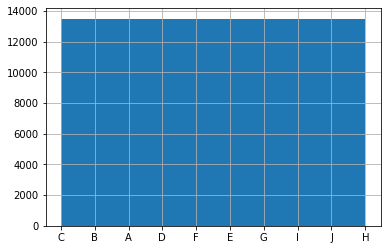

In [199]:
y_SMOTE.hist()

In [200]:
X_SMOTE

,DISCOVERY_DOY,DISCOVERY_TIME,LATITUDE,LONGITUDE,FIPS_NAME,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,STATE_ORD,FIRE_SIZE,FIRE_YEAR
0,35,35.000000,29.715800,82.832200,463,2,10,7,4.000000,2002
1,267,267.000000,39.603889,121.623889,171,9,2,4,2.000000,2003
2,201,201.000000,42.888860,76.997520,880,7,12,32,0.050350,2018
3,105,105.000000,41.076290,75.959530,719,4,1,36,2.000000,2017
4,128,128.000000,33.032767,116.954878,1044,5,5,4,0.100000,2007
...,...,...,...,...,...,...,...,...,...,...
134995,223,223.991631,45.250664,106.260564,957,8,7,24,10735.247919,2007
134996,118,118.885808,31.729054,104.420384,308,4,8,39,32957.614123,2009
134997,103,103.485441,30.557182,101.778579,320,4,8,41,31111.880069,2010
134998,232,232.530906,40.800343,116.112741,478,7,8,9,36633.552115,2003


In [201]:
y_SMOTE

0         C
1         B
2         A
3         B
4         A
         ..
134995    J
134996    J
134997    J
134998    J
134999    J
Name: FIRE_SIZE_CLASS, Length: 135000, dtype: object

In [202]:
Fires_SMOTE = pd.concat([X_SMOTE, y_SMOTE], axis=1)
Fires_SMOTE

,DISCOVERY_DOY,DISCOVERY_TIME,LATITUDE,LONGITUDE,FIPS_NAME,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,STATE_ORD,FIRE_SIZE,FIRE_YEAR,FIRE_SIZE_CLASS
0,35,35.000000,29.715800,82.832200,463,2,10,7,4.000000,2002,C
1,267,267.000000,39.603889,121.623889,171,9,2,4,2.000000,2003,B
2,201,201.000000,42.888860,76.997520,880,7,12,32,0.050350,2018,A
3,105,105.000000,41.076290,75.959530,719,4,1,36,2.000000,2017,B
4,128,128.000000,33.032767,116.954878,1044,5,5,4,0.100000,2007,A
...,...,...,...,...,...,...,...,...,...,...,...
134995,223,223.991631,45.250664,106.260564,957,8,7,24,10735.247919,2007,J
134996,118,118.885808,31.729054,104.420384,308,4,8,39,32957.614123,2009,J
134997,103,103.485441,30.557182,101.778579,320,4,8,41,31111.880069,2010,J
134998,232,232.530906,40.800343,116.112741,478,7,8,9,36633.552115,2003,J


In [203]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_SMOTE_train = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
X_SMOTE_test = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] < 2018]['FIRE_SIZE']
y_SMOTE_train = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_SMOTE_test = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] == 2018]['FIRE_SIZE']

In [204]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor]
model_scores_SMOTE = dict()    
model_SMOTE_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE'])
for model in model_list:
  regressor_SMOTE = model().fit(X_SMOTE_train,X_SMOTE_test)
  y_SMOTE_pred = regressor_SMOTE.predict(y_SMOTE_train)
  model_SMOTE_mse = mean_squared_error(y_SMOTE_pred,y_SMOTE_test)
  model_SMOTE_mae = mean_absolute_error(y_SMOTE_pred,y_SMOTE_test)
  model_scores_SMOTE[model] = (regressor_SMOTE,y_SMOTE_test,y_SMOTE_pred)
  model_SMOTE_df = model_SMOTE_df.append({'Model':model,'MSE':model_SMOTE_mse,'MAE':model_SMOTE_mae}, ignore_index=True)
  model_SMOTE_df = model_SMOTE_df.sort_values(by='MSE', ascending= True)
model_SMOTE_df

,Model,MSE,MAE
0,<class 'sklearn.ensemble._forest.RandomForestR...,4.287180e+06,464.699734
1,<class 'sklearn.ensemble._gb.GradientBoostingR...,3.898169e+07,4118.593207
2,<class 'sklearn.linear_model._base.LinearRegre...,3.932550e+07,5294.361666
4,<class 'sklearn.neighbors._regression.KNeighbo...,9.658994e+07,2330.627939
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,1.218363e+08,7213.978963


# Trial 7: SMOTE (Oversampling) : Classification



- Original Dataset

In [13]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
X_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] < 2018]['FIRE_SIZE_CLASS']
y_KNN_train = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_KNN_test = Fires_KNN[Fires_KNN['FIRE_YEAR'] == 2018]['FIRE_SIZE_CLASS']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

model_list = [RidgeClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
               KNeighborsClassifier]
model_scores_KNN = dict()    
model_KNN_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])
for model in model_list:
  regressor_KNN = model().fit(X_KNN_train,X_KNN_test)
  y_KNN_pred = regressor_KNN.predict(y_KNN_train)
  model_KNN_accuracy = accuracy_score(y_KNN_pred,y_KNN_test)
  model_KNN_f1 = f1_score(y_KNN_pred,y_KNN_test, average='micro')
  model_KNN_precision = precision_score(y_KNN_pred,y_KNN_test, average='micro')
  model_KNN_recall = recall_score(y_KNN_pred,y_KNN_test, average='micro')
  model_scores_KNN[model] = (regressor_KNN,y_KNN_test,y_KNN_pred)
  model_KNN_df = model_KNN_df.append({'Model':model,'Accuracy':model_KNN_accuracy,'F1':model_KNN_f1, 'Precision':model_KNN_precision, 'Recall':model_KNN_recall}, ignore_index=True)
  model_KNN_df = model_KNN_df.sort_values(by='F1', ascending= False)
model_KNN_df

,Model,Accuracy,F1,Precision,Recall
0,<class 'sklearn.ensemble._forest.RandomForestC...,0.636704,0.636704,0.636704,0.636704
1,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.634207,0.634207,0.634207,0.634207
2,<class 'sklearn.ensemble._gb.GradientBoostingC...,0.626717,0.626717,0.626717,0.626717
4,<class 'sklearn.neighbors._classification.KNei...,0.579276,0.579276,0.579276,0.579276
3,<class 'sklearn.linear_model._ridge.RidgeClass...,0.520599,0.520599,0.520599,0.520599


In [52]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(sampling_strategy='not majority', random_state=42)
train_SMOTE = Fires_KNN[['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD','FIRE_SIZE','FIRE_YEAR']]
target_SMOTE = Fires_KNN['FIRE_SIZE_CLASS']
X_SMOTE, y_SMOTE = sm.fit_resample(train_SMOTE, target_SMOTE)
Fires_SMOTE = pd.concat([X_SMOTE, y_SMOTE], axis=1)
Fires_SMOTE

,DISCOVERY_DOY,DISCOVERY_TIME,LATITUDE,LONGITUDE,FIPS_NAME,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,STATE_ORD,FIRE_SIZE,FIRE_YEAR,FIRE_SIZE_CLASS
0,298,298.000000,34.778964,-89.804780,401,10,1,25,10.000000,1995,C
1,316,316.000000,29.834055,-94.343419,721,11,5,44,0.100000,2011,A
2,124,124.000000,39.037959,-80.659648,838,5,7,50,1.000000,1992,B
3,30,30.000000,32.041910,-99.135269,177,1,2,44,1.000000,2014,B
4,157,157.000000,39.638700,-104.761200,46,6,5,5,0.010000,2017,A
...,...,...,...,...,...,...,...,...,...,...,...
256321,150,150.640402,35.442099,-115.359778,979,5,8,3,16327.935102,2017,G
256322,228,228.425235,42.938974,-101.655344,201,8,7,26,5481.068926,2004,G
256323,179,179.270402,42.635970,-113.520670,1363,6,6,16,28716.943757,2006,G
256324,174,174.611631,36.940083,-118.596780,1467,6,6,7,15950.316384,2017,G


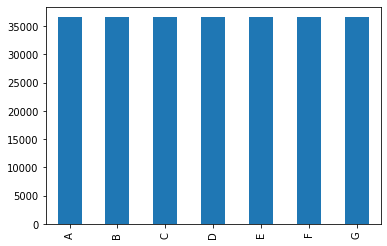

In [53]:
fires_class = Fires_SMOTE['FIRE_SIZE_CLASS']
fires_class.value_counts().sort_index().plot(kind='bar')

In [55]:
#### split data into training and testing
# Training : 1992-2017 data
# Testing : 2018 data
X_SMOTE_train = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] < 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
X_SMOTE_test = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] < 2018]['FIRE_SIZE_CLASS']
y_SMOTE_train = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] == 2018][['DISCOVERY_DOY','DISCOVERY_TIME','LATITUDE','LONGITUDE','FIPS_NAME','DISCOVERY_MONTH','NWCG_CAUSE_CLASSIFICATION_ORD','STATE_ORD']]
y_SMOTE_test = Fires_SMOTE[Fires_SMOTE['FIRE_YEAR'] == 2018]['FIRE_SIZE_CLASS']

In [ ]:
#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [RidgeClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
               KNeighborsClassifier]
model_scores_SMOTE = dict()    
model_SMOTE_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1', 'Precision', 'Recall'])
for model in model_list:
  regressor_SMOTE = model().fit(X_SMOTE_train,X_SMOTE_test)
  y_SMOTE_pred = regressor_SMOTE.predict(y_SMOTE_train)
  model_SMOTE_accuracy = accuracy_score(y_SMOTE_pred,y_SMOTE_test)
  model_SMOTE_f1 = f1_score(y_SMOTE_pred,y_SMOTE_test, average='micro')
  model_SMOTE_precision = precision_score(y_SMOTE_pred,y_SMOTE_test, average='micro')
  model_SMOTE_recall = recall_score(y_SMOTE_pred,y_SMOTE_test, average='micro')
  model_scores_SMOTE[model] = (regressor_SMOTE,y_SMOTE_test,y_SMOTE_pred)
  model_SMOTE_df = model_SMOTE_df.append({'Model':model,'Accuracy':model_SMOTE_accuracy,'F1':model_SMOTE_f1, 'Precision': model_SMOTE_precision, 'Recall': model_SMOTE_recall}, ignore_index=True)
  model_SMOTE_df = model_SMOTE_df.sort_values(by='F1', ascending= False)
model_SMOTE_df

,Model,Accuracy,F1,Precision,Recall
0,<class 'sklearn.ensemble._forest.RandomForestC...,0.697219,0.697219,0.697219,0.697219
1,<class 'sklearn.ensemble._gb.GradientBoostingC...,0.606591,0.606591,0.606591,0.606591
4,<class 'sklearn.neighbors._classification.KNei...,0.510814,0.510814,0.510814,0.510814
2,<class 'sklearn.ensemble._weight_boosting.AdaB...,0.450051,0.450051,0.450051,0.450051
3,<class 'sklearn.linear_model._ridge.RidgeClass...,0.290422,0.290422,0.290422,0.290422
